# Sticky Header Editing AB Test Analysis Report

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** Last update: 07 December 2022**

[TASK](https://phabricator.wikimedia.org/T294506) | [CODEBASE](https://gitlab.wikimedia.org/mneisler/sticky-header-editing-affordance-analysis-2022)

# Table of Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Edit Completion Rate](#Edit-Completion-Rate)
4. [Revert Rate](#Revert-Rate)
5. [Edit Engagement](#Edit-Engagement)


# Introduction

In [T283505](https://phabricator.wikimedia.org/T283505), the Web team introduced additional functionality that allows access to commonly used tools previously available only at the top throughout the page via a “sticky” or “fixed” header. The goal of the new stick header is to make it easier for readers and editors to access the tools they frequently need without needing to scroll all the way to the top of the page.

Initially, the sticky header did not contain editing functionalitly per [T294383](https://phabricator.wikimedia.org/T294383). An AB test was run to evaluate the impact introducing an edit button within desktop reading experience's fixed "sticky" site header has on the following:

* The speed and ease with which contributors, across experience levels, can begin making a change to the content they are wanting to affect
* How likely people are to publish the edits they start making
* Peoples' awareness of their ability to edit the content they are consuming
* The rate at which people make destructive changes to wikis

The AB test included all logged-in users that visited the one the participating Wikipedias during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T304027) and conditions outlined in the methodology section below). During this test, 50% of users included in the test had access to the Sticky Header Edit button, and 50% did not.

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Sticky_Header?useskin=vector-2022).

# Methodology

The AB test was run on a per Wikipedia basis and was only applied logged-in users. Users included in the test were randomly assigned to either a control or treatment group. There were two AB Tests run with varying control and treatment conditions as described below. 

* **AB Test Experiment 1 (Stick header control)**: 
  * AB Test Duration: 6 July 2022 through 8 August 2022
  * 15 wikis*. See full list defined in [T298280](https://phabricator.wikimedia.org/T298280). #AB Test was also deployed at Office Wiki and Wikimedia Incubator were excluded from this analysis
  * Prior to start of this AB Test, wikiy already had access to the sticky heaer. 
  * In this test, there were two groups:
      * Control: Sticky header without edit button
      * Treatment 2: Sticky header with edit button
* **AB Test Experiment 2 (no sticky header control)**:
  * AB Test Duration:  16 August 2022*  through 1 September 2022. Note: * events were logged before then but we correctly start logging events on 16 Aug 2022.
   * Wikis: Vietnamese Wikipedia (viwiki) and Indonesian Wikipedia (idwiki)
     * Prior to the start of this A/B test, these wikis did not have access to the sticky header.
  * In this test, there were three groups: 
     * Control: No sticky header
     * Treatment 1: Sticky header without edit button 
     * Treatment 2: Sticky header with edit buttons
     
See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:
* [Define Wikis for the Test](https://phabricator.wikimedia.org/T298280#7620139)
* [Sticky Header Measurement Plan](https://docs.google.com/document/d/1g5idrT98giBSHYVlhAjLEvbLbJagFH7DTNd8IsUY8Cw/edit#heading=h.fvxcp9oslm4g)
* Instrumentation
  * [Track clicks in EditAttemptStep](https://phabricator.wikimedia.org/T298634)
  * [Track clicks in DesktopWebUIActions](https://phabricator.wikimedia.org/T304072)
* [Implement Sticky Header AB Test](https://phabricator.wikimedia.org/T299959)
*  Test Group 1 (Stick header control): 
   * [Enable Sticky Header AB Test](https://phabricator.wikimedia.org/T311144)
   * [Disable Sticky Header AB Test for all pilot wikis](https://phabricator.wikimedia.org/T312296)
* Test Group 2 (no sticky header control):
   * [Enable Sticky Header AB Test for idwiki and viwiki](https://phabricator.wikimedia.org/T312295)
   * [Disble Sticky Header AB Test for idwiki and viwiki](https://phabricator.wikimedia.org/T315264)


## Data Issues:
* Bucketing data used to distinguish between session in the the control and treatment group is contained in the[web ab test enrollment schema](https://schema.wikimedia.org/repositories/secondary/jsonschema/analytics/mediawiki/web_ab_test_enrollment/current.yaml). At this time of this analysis, a portion of this bucketing data had already been scrubbed as it was past 90 days. As a result, we have limited bucketing info for the AB Test Group #1.
* Implications:
  * We don’t know the difference between a person using an existing editing affordance in the control vs treatment group. 
  * Harder to determine if the precense of the sticky header editing affordance had any potential impact on the use of existing editing affordances
* Workarounds
   * With existing data, we can still directly compare the use of the sticky header vs use of other editing buttons for AB Test group #1.
   * Working with DE to see if we can get bucketing data backfilled in T323664

In [138]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(lubridate)
    # Tables:
    library(gt)
    library(gtsummary)
    # Misc
    library(dplyr, warn.conflicts = FALSE)
})

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)
options(dplyr.summarise.inform = FALSE)

# Edit Completion Rate

Question: Are people more or less likely to publish the edits they initiate?

For the purpose of this analysis, we are defining the completion rate as the percent of contributors that successfully published (`event.action = 'saveSuccess'` in EditAttemptStep)at least once edit after clicking an edit affordance (`event.action = 'init'`) during the time of the AB test. We reviewed edits intiated with the sticky header compared to edits iniaited using all other available edit initiation methods available on the page.

A couple notes:
* Bucketing data for AB Test Group #1 group was removed prior to the start of the analysis. As a result, we revieweed the edit completion rate for each editing initiation type (sticky header editing affordance or existing editing affordance) instead of by treatment group. The use of the sticky header editing button is less frequent than other available editing methods in each group so reviewing edits specifically completed with the sticky editor also helps us isolate any changes directly associated with the new affordance. 
* This definition of of edit attempt steps does not take into account the number of attempts it took for the user to publish or the duration of their editing sessions. 
* Edits made using [discussiontools](https://www.mediawiki.org/wiki/Extension:DiscussionTools?useskin=vector-2022) were not included as they are only used on talk pages where the sticky header is not currently available.

## AB Test Experiment 1 (Sticky header control): 

  * AB Test Duration: 6 July 2022 through 8 August 2022
  * 15 wikis. See full list defined in [T298280](https://phabricator.wikimedia.org/T298280).
  * Data Issue:  The majority of bucketing data for AB Test Experiment #1  was unavailable at the start of the analysis because it was scrubbed after 90 days. As a result, we reviewed the edit completion rate for each editing initiation type (sticky header editing affordance or other) instead of by test group. The use of the sticky header editing button is less frequent than other available editing methods in each group so reviewing edits specifically completed with the sticky editor helps us isolate any changes directly associated with the new affordance. However, we will not be able to tell if the presence of the edit button in the sticky header had an impact on the edit completion rate using other editing initiation types.

In [71]:
#collect all sticky header edit attempts for the first group
query <-
"
WITH edit_attempts AS (
    SELECT
      wiki AS wiki,
      event.user_id as user_id,
      event.editing_session_id as edit_attempt_id,
      event.is_oversample AS is_oversample,
      IF(event.init_mechanism IN ('click-sticky-header', 'click-new-sticky-header', 'url-new-sticky-header', 'url-sticky-header'), 'sticky_header', 'other') AS editing_method,
      event.user_editcount AS experience_level
    FROM event_sanitized.editattemptstep
    WHERE
-- only in participating wikis
    wiki IN ('euwiki', 'frwiki', 'frwiktionary','hewiki', 'fawiki', 'ptwikiversity', 'bnwiki'
'dewikivoyage', 'kowiki', 'ptwiki', 'srwiki', 'trwiki', 'vecwiki')
-- AB test dates
    AND ((year = 2022 AND month = 07 AND day > 06) OR 
        (year = 2022 and month = 08 And day <= 08))
-- look at only desktop events
    AND event.platform = 'desktop'
-- only registered user
    AND event.user_id != 0
    AND event.action = 'init'
    AND event.integration = 'page'
),

-- find all published edits
published_edits AS (
SELECT
     event.user_id as user_id,
     event.editing_session_id AS edit_save_id,
     wiki AS wiki
     FROM event_sanitized.editattemptstep
     WHERE
    wiki IN ('euwiki', 'frwiki', 'frwiktionary','hewiki', 'fawiki', 'ptwikiversity', 'bnwiki'
'dewikivoyage', 'kowiki', 'ptwiki', 'srwiki', 'trwiki', 'vecwiki')
-- AB test dates
    AND ((year = 2022 AND month = 07 AND day > 06) OR 
        (year = 2022 and month = 08 And day <= 08))
   AND event.action = 'saveSuccess'
)

-- main query
SELECT
    eas.wiki,
    eas.user_id,
    edit_attempt_id,
    is_oversample,
    editing_method,
-- was saved 
    IF (published_edits.edit_save_id IS NOT NULL, 1, 0) AS edit_success,
    experience_level
FROM edit_attempts eas
LEFT JOIN published_edits ON
    eas.edit_attempt_id = published_edits.edit_save_id AND
    eas.wiki = published_edits.wiki

"

In [72]:
sticky_header_edits_group1 <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [73]:
# data reformatting and cleanup

#set factor levels with correct baselines

sticky_header_edits_group1$edit_success <-
  factor(
    sticky_header_edits_group1$edit_success,
    levels = c(0, 1),
    labels = c("Not Complete", "Complete")
  )

sticky_header_edits_group1$editing_method <-
  factor(
    sticky_header_edits_group1$editing_method,
    levels = c('other', 'sticky_header'),
    labels = c('Existing editing button', 'Sticky Header')
  )



# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
sticky_header_edits_group1$user_id <-
  as.character(paste(sticky_header_edits_group1$user_id, sticky_header_edits_group1$wiki, sep ="-"))

#clarfiy wiki names
sticky_header_edits_group1 <- sticky_header_edits_group1 %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'euwiki' ~ "Basque Wikipedia",
      wiki == 'frwiki' ~ "French Wikipedia",
      wiki == 'frwiktionary' ~ "French Wiktionary",
      wiki == 'hewiki' ~ 'Hebrew Wikipedia',
      wiki == 'fawiki' ~ 'Persian Wikipedia',
      wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
      wiki == 'bnwiki' ~ 'Bengali Wikipedia',
      wiki == 'dewikivoyage' ~ 'German Wikivoyage',
      wiki == 'kowiki' ~ 'Korean Wikipedia',
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia',  
      wiki == 'srwiki' ~ 'Serbian Wikipedia'   ,
      wiki == 'trwiki' ~ 'Turkish Wikipedia',
      wiki == 'vecwiki' ~ 'Venetian Wikipedia'
    )
  ) 


### Edit attempts 

We first took a look at the propotion of edit attempts logged for each button type.  Since all Discussion Tool events events are oversampled (100% sampling rate) in EditAttemptStep, we removed oversampled events so we can directly compare the balance between each experiment group.

In [148]:
sticky_header_edit_attempts_overall <- sticky_header_edits_group1 %>%
   filter(is_oversample == 'false') %>%  # remove oversampled DT events
  group_by(editing_method) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
   mutate(pct_users = paste0(round(users / sum(users) * 100, 2), "%"))

sticky_header_edit_attempts_overall

editing_method          users attempts pct_users
1 Existing editing button 18997 234705   97.89%   
2 Sticky Header             410    649   2.11%

There were 410 total distinct users in the AB test that made an edit attempt using the new stick header editing affordance. This represents about 2% of all users in the experiment.

Note: Due to missing bucketing data, we do not know which of these users were assigned to a test group vs a control group

### Overall Completion Rate by Editing Initiation Type

In [149]:
edit_completion_rate_group1 <- sticky_header_edits_group1 %>%
    group_by (editing_method, wiki, user_id) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_completions = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              edit_success = ifelse(sum(n_completions >= 1), 'Complete', 'Not Complete'),  #redefine edit success as user completed at least 1 edit attempt
    .groups = 'drop') 

In [150]:
edit_completion_rate_overall_group1  <- edit_completion_rate_group1  %>%
    group_by(editing_method) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  )  %>%
    mutate(experiment_group = "ab_test_1") # add row to classify group



In [151]:
# Create table of completion rate
edit_completion_rate_overall_group1_table <- edit_completion_rate_overall_group1  %>%
  select(-c(5)) %>% # remove uneeded row
  gt() %>%
  tab_header(
    title = "AB Test Experiment #1: Edit completion rate by editing initiation type",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    editing_method = "Editing initiation type",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Edit completion rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that attempted and published at least 1 new topic",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #1: Run on 15 wikis, Control had sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
    gtsave(
    "edit_completion_rate_overall_group1_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_completion_rate_overall_group1_table, file = "edit_completion_rate_overall_group1_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #1: Edit completion rate by editing initiation type 1 
 
 
 across all participating Wikipedias 
 
 
 
 
 Editing initiation type 
 Number of users attempted 
 Number of users completed 
 Edit completion rate 2 
 
 
 
 
 Existing editing button 
 19152 
 11695 
 61.1% 
 
 
 Sticky Header 
 414 
 260 
 62.8% 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #1: Run on 15 wikis, Control had sticky header
 
 
 
 
 2 
 
 
 Defined as percent of contributors that attempted and published at least 1 new topic

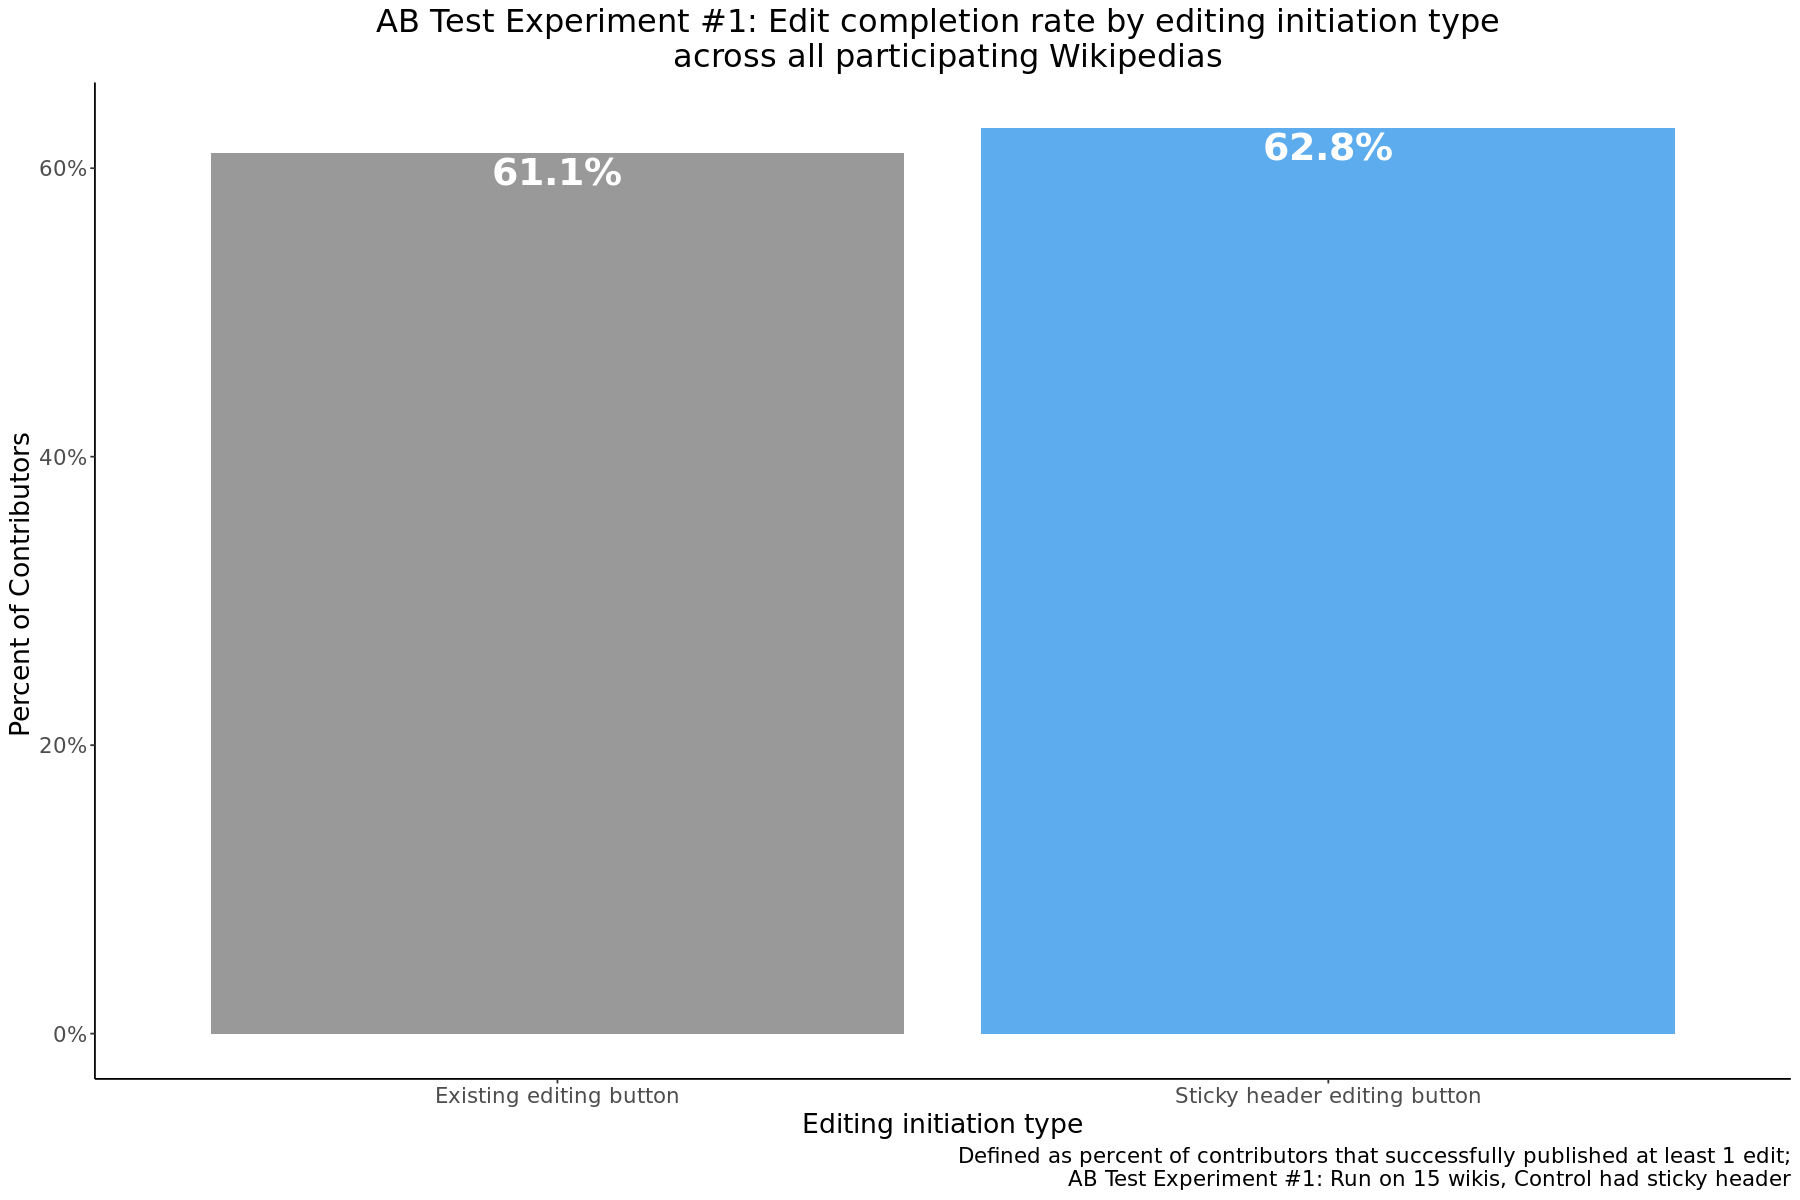

In [152]:
p <- edit_completion_rate_overall_group1  %>%
    ggplot(aes(x= editing_method, y = n_users_completed / n_users, fill = editing_method)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Existing editing button", "Sticky header editing button")) +
    labs (y = "Percent of Contributors ",
          x = "Editing initiation type",
          title = "AB Test Experiment #1: Edit completion rate by editing initiation type \n across all participating Wikipedias",
         caption = "Defined as percent of contributors that successfully published at least 1 edit;
AB Test Experiment #1: Run on 15 wikis, Control had sticky header")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_completion_rate_overall_group1.png", p, width = 16, height = 8, units = "in", dpi = 300)

There was a 2.8% increase in the percent of contributors that were able to successfully complete an editing using the sticky header editing affordance in AB Test Experiment #1. Note that for the existing editing affodance edits we do not know if the user had access to stiky header editing button or not due to the missing bucketing info.

### By Participating Wikipedia

In [153]:
edit_completion_rate_bywiki_group1  <-  edit_completion_rate_group1  %>%
    group_by(wiki, editing_method) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) %>%
     #determine credible intervals
    cbind(as.data.frame(binom:::binom.bayes(x = .$n_users_completed, n = .$n_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

In [154]:
# Create table of completion rate by participating wikipedia
edit_completion_rate_bywiki_group1_table <- edit_completion_rate_bywiki_group1 %>%
  select(c(1,2,3,4,5,12,13)) %>% #select needed rows
  gt() %>%
  tab_header(
    title = "AB Test Experiment #1: Edit completion rate by editing initiation type",
    subtitle = "at each participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    editing_method = "Editing initiation type",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "New topic completion rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that attempted and published at least 1 new topic",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #1: Run on 15 wikis, Control had sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "edit_completion_rate_bywiki_group1_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_completion_rate_bywiki_group1_table, file = "edit_completion_rate_bywiki_group1_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #1: Edit completion rate by editing initiation type 1 
 
 
 at each participating Wikipedia 
 
 
 
 
 Wikipedia 
 Editing initiation type 
 Number of users attempted 
 Number of users completed 
 New topic completion rate 2 
 CI (Lower Bound) 3 
 CI (Upper Bound) 3 
 
 
 
 
 Basque Wikipedia 
 Existing editing button 
 108 
 76 
 70.4% 
 0.62 
 0.79 
 
 
 French Wikipedia 
 Existing editing button 
 10339 
 6547 
 63.3% 
 0.62 
 0.64 
 
 
 French Wikipedia 
 Sticky Header 
 244 
 153 
 62.7% 
 0.57 
 0.69 
 
 
 French Wiktionary 
 Existing editing button 
 192 
 118 
 61.5% 
 0.55 
 0.68 
 
 
 French Wiktionary 
 Sticky Header 
 2 
 0 
 0% 
 0.00 
 0.57 
 
 
 Hebrew Wikipedia 
 Existing editing button 
 2001 
 1330 
 66.5% 
 0.64 
 0.69 
 
 
 Hebrew Wikipedia 
 Sticky Header 
 49 
 35 
 71.4% 
 0.58 
 0.83 
 
 
 Korean Wikipedia 
 Existing editing button 
 1026 
 688 
 67.1% 
 0.64 
 0.70 
 
 
 Korean Wikipedia 
 Sticky Header 
 11 
 6 
 54.5% 
 0.27 
 0.80 
 
 
 Persian Wikipedia 
 Existing editing button 
 1282 
 715 
 55.8% 
 0.53 
 0.58 
 
 
 Persian Wikipedia 
 Sticky Header 
 20 
 9 
 45% 
 0.25 
 0.66 
 
 
 Portuguese Wikipedia 
 Existing editing button 
 2705 
 1481 
 54.8% 
 0.53 
 0.57 
 
 
 Portuguese Wikipedia 
 Sticky Header 
 62 
 42 
 67.7% 
 0.56 
 0.79 
 
 
 Portuguese Wikiversity 
 Existing editing button 
 32 
 14 
 43.8% 
 0.27 
 0.61 
 
 
 Portuguese Wikiversity 
 Sticky Header 
 1 
 1 
 100% 
 0.23 
 1.00 
 
 
 Serbian Wikipedia 
 Existing editing button 
 283 
 189 
 66.8% 
 0.61 
 0.72 
 
 
 Serbian Wikipedia 
 Sticky Header 
 3 
 3 
 100% 
 0.56 
 1.00 
 
 
 Turkish Wikipedia 
 Existing editing button 
 1177 
 532 
 45.2% 
 0.42 
 0.48 
 
 
 Turkish Wikipedia 
 Sticky Header 
 22 
 11 
 50% 
 0.30 
 0.70 
 
 
 Venetian Wikipedia 
 Existing editing button 
 7 
 5 
 71.4% 
 0.39 
 0.96 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #1: Run on 15 wikis, Control had sticky header
 
 
 
 
 2 
 
 
 Defined as percent of contributors that attempted and published at least 1 new topic
 
 
 
 
 3 
 
 
 95% credible intervals. There is a 95% probability that the parameter lies in this interval

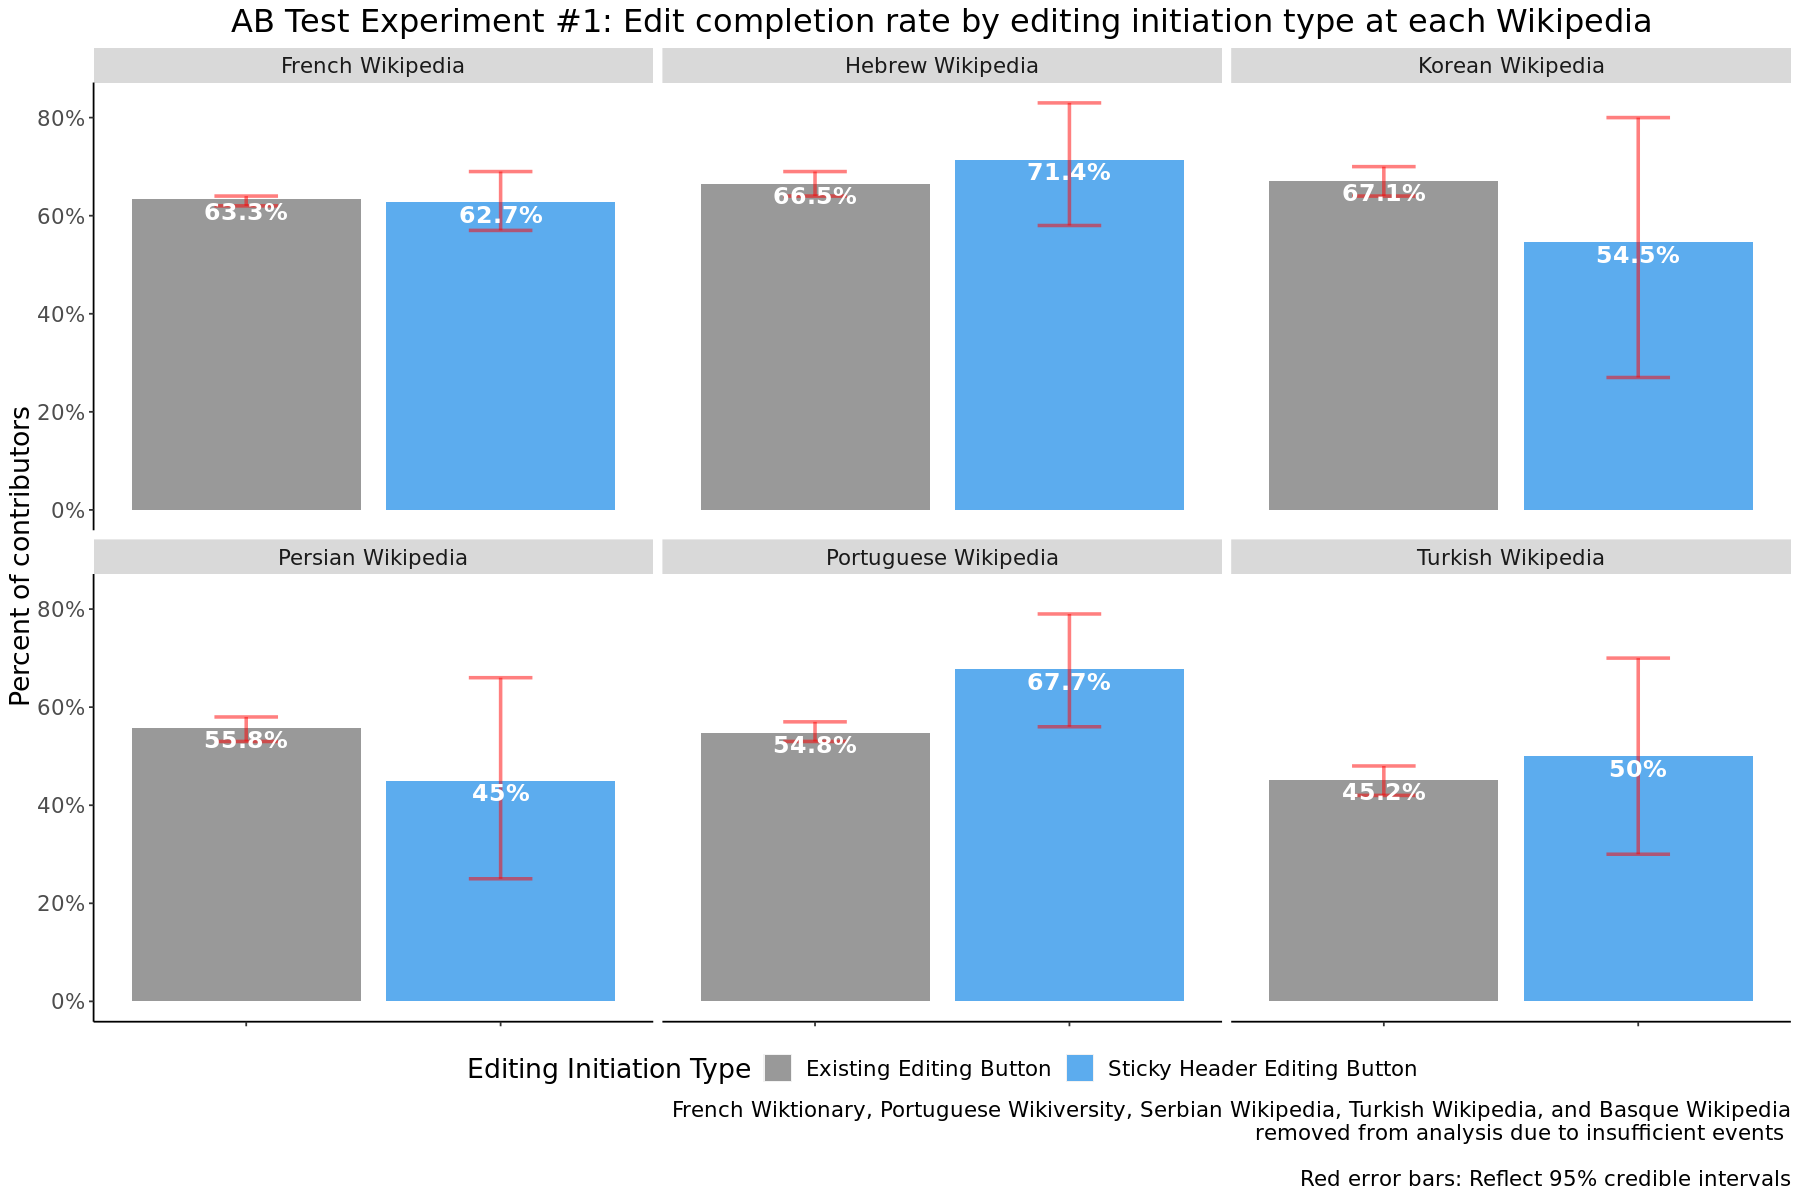

In [155]:
# Plot edit completion rates for each wiki  

dodge <- position_dodge(width=0.9)

p <- edit_completion_rate_bywiki_group1  %>%
    filter(!(wiki %in% c('French Wiktionary', 'Portuguese Wikiversity', 'Serbian Wikipedia', 'Venetian Wikipedia', 'Basque Wikipedia'))) %>% # remove wikis where there are under 10 events as we 
    ggplot(aes(x= editing_method, y = n_users_completed / n_users, fill = editing_method)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "AB Test Experiment #1: Edit completion rate by editing initiation type at each Wikipedia",
         caption = "French Wiktionary, Portuguese Wikiversity, Serbian Wikipedia, Turkish Wikipedia, and Basque Wikipedia
removed from analysis due to insufficient events \n
         Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Initiation Type", labels = c("Existing Editing Button", "Sticky Header Editing Button"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completion_rate_bywiki_group1.png", p, width = 16, height = 8, units = "in", dpi = 300)

Results vary on a per Wikipedia basis.

It is important to note that there is a high level of uncertainty around some of these per Wikipedia completion rate values due to the smaller number of edit attempts recorded on a per Wikipedia basis, especially for smaller sized Wikipedias (as represented by larger red error bars on the chart above). We can be more confident in the identified completion rate values for Wikipedias with more data and smaller error bars such as French, Portuguese, and Hebrew Wikipedia, which all had higher or similar completion rates betweeen the two editing affordance types.

## AB Test Experiment #2: Sticky Header No Control

  * AB Test Duration:  16 August 2022*  through 1 September 2022. Note: * events were logged before then but we correctly start logging events on 16 Aug 2022.
  * Wikis: Vietnamese Wikipedia (viwiki) and Indonesian Wikipedia (idwiki)
  * The start of this A/B test will mark the first time these wikis are gaining access to the sticky header.
  * We do have complete bucketing info at the start of this analysis so we will review edit completion rates by both bucket and edit type. 

In [ ]:
#collect all sticky header edit attempts for the second group
query <-
"
WITH edit_attempts AS (
    SELECT
      wiki AS wiki,
      event.user_id as user_id,
      event.editing_session_id as edit_attempt_id,
      event.session_token as session_token,
      event.is_oversample AS is_oversample,
      IF(event.init_mechanism IN ('click-sticky-header', 'click-new-sticky-header', 'url-new-sticky-header', 'url-sticky-header'), 'sticky_header', 'other') AS editing_method,
      event.user_editcount AS experience_level
    FROM event.editattemptstep 
  WHERE
-- only in participating wikis
     wiki IN ('viwiki', 'idwiki')
-- AB test dates
   AND ((year = 2022 AND month = 08 AND day >= 16) OR 
        (year = 2022 and month = 09 And day = 01))
-- look at only desktop events
    AND event.platform = 'desktop'
-- only registered user
    AND event.user_id != 0
    AND event.action = 'init'
),

-- find all published edits
published_edits AS (
SELECT
     event.user_id as user_id,
     event.editing_session_id AS edit_save_id,
     wiki AS wiki
     FROM event.editattemptstep
     WHERE
    wiki IN ('viwiki', 'idwiki')
-- AB test dates
    AND ((year = 2022 AND month = 08 AND day >= 16) OR 
        (year = 2022 and month = 09 And day = 01))
   AND event.action = 'saveSuccess'
),

-- find bucketing info
ab_sessions AS (
SELECT
    wiki AS wiki,
    `group` AS test_group,
    web_session_id AS session
FROM
    event.mediawiki_web_ab_test_enrollment
WHERE
    ((year = 2022 AND month = 08 AND day >= 16) OR 
    (year = 2022 and month = 09 And day = 01))
    AND experiment_name = 'vector.sticky_header_edit'
    AND wiki IN ('idwiki', 'viwiki')
    AND is_anon = false
    AND is_bot = false
)

-- main query
SELECT
    eas.wiki,
    eas.user_id,
    edit_attempt_id,
    ab_sessions.test_group,
    eas.session_token,
    eas.is_oversample,
    eas.editing_method,
-- was saved 
    IF (published_edits.edit_save_id IS NOT NULL, 1, 0) AS edit_success,
    eas.experience_level
FROM edit_attempts eas
INNER JOIN ab_sessions
ON eas.session_token = ab_sessions.session
LEFT JOIN published_edits ON
    eas.edit_attempt_id = published_edits.edit_save_id AND
    eas.wiki = published_edits.wiki
"

In [ ]:
sticky_header_edits_group2 <-  wmfdata::query_hive(query)

In [ ]:
# #save data to review if needed
# write.csv(sticky_header_edits_group2,
#     file = 'Data/sticky_header_edits_group2.csv'
#   ) 

In [29]:
sticky_header_edits_group2 <-
  read.csv(
    file = 'Data/sticky_header_edits_group2.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 

In [30]:
# data reformatting and cleanup

#set factor levels with correct baselines


sticky_header_edits_group2$test_group <-
  factor(
    sticky_header_edits_group2$test_group,
    levels = c("noStickyHeaderControl", "stickyHeaderNoEditButtonTreatment1", "stickyHeaderEditButtonTreatment2"),
    labels = c("No Sticky Header (Control) ", "Sticky Header with No Edit Button", "Sticky Header with Edit Button")
  )

sticky_header_edits_group2$edit_success <-
  factor(
    sticky_header_edits_group2$edit_success,
    levels = c(0, 1),
    labels = c("Not Complete", "Complete")
  )

sticky_header_edits_group2$editing_method <-
  factor(
    sticky_header_edits_group2$editing_method,
    levels = c('other', 'sticky_header'),
    labels = c('Existing editing button', 'Sticky Header')
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
sticky_header_edits_group2$user_id <-
  as.character(paste(sticky_header_edits_group2$user_id, sticky_header_edits_group2$wiki, sep ="-"))

#clarfiy wiki names
sticky_header_edits_group2 <- sticky_header_edits_group2 %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'idwiki' ~ "Indonesian Wikipedia",
      wiki == 'viwiki' ~ "Vietnamese Wikipedia"
    )
  ) 

### Edit Attempts

In [31]:
sticky_header_2_edit_attempts_overall <- sticky_header_edits_group2 %>%
   filter(is_oversample == 'false') %>%  # remove oversampled DT events
  group_by(test_group) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
   mutate(pct_users = paste0(round(users / sum(users) * 100, 2), "%"))

sticky_header_2_edit_attempts_overall

test_group                        users attempts pct_users
1 No Sticky Header (Control)        158   405      32.92%   
2 Sticky Header with No Edit Button 169   679      35.21%   
3 Sticky Header with Edit Button    153   361      31.87%

In [32]:
sticky_header_2_edit_attempts_overall_bymethod <- sticky_header_edits_group2 %>%
   filter(is_oversample == 'false') %>%  # remove oversampled DT events
  group_by(editing_method) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id)) %>%
   mutate(pct_users = paste0(round(users / sum(users) * 100, 2), "%"))

sticky_header_2_edit_attempts_overall_bymethod

editing_method          users attempts pct_users
1 Existing editing button 459   1405     96.03%   
2 Sticky Header            19     26     3.97%

We see an expected 1/3 split of users across all three test groups in this experiment. About 19 distinct users (4% of all users) made an edit using the Sticky header during the AB experiment.

### Overall Completion Rate by Test Group and Editing Initiation Type

In [33]:
# Completion Rate for Test Group 2
edit_completion_rate_group2 <- sticky_header_edits_group2 %>%
    group_by(test_group, editing_method, wiki, user_id) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_completions = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              edit_success = ifelse(sum(n_completions >= 1), 'Complete', 'Not Complete'),  #redefine edit success as user completed at least 1 edit attempt
    .groups = 'drop')  

In [34]:

edit_completion_rate_bytestgroup_group2  <- edit_completion_rate_group2  %>%
    group_by(test_group, editing_method) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) 


In [35]:
# Create table of completion rate by editing method and test group
edit_completion_rate_group2_table <- edit_completion_rate_bytestgroup_group2 %>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment 2: Edit Completion Rates by editing intiation type and test group",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    test_group = "Test Group",
    editing_method = "Editing Method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Edit completion rate",
  ) %>%
tab_footnote(
    footnote = "Completion rate defined as parcent of users that published at least 1 edit",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run on 2 wikis, Control had no sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
    gtsave(
    "edit_completion_rate_group2_table.html", inline_css = TRUE) 

IRdisplay::display_html(data = edit_completion_rate_group2_table,  file = "edit_completion_rate_group2_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment 2: Edit Completion Rates by editing intiation type and test group 1 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Editing Method 
 Number of users attempted 
 Number of users completed 
 Edit completion rate 2 
 
 
 
 
 No Sticky Header (Control) 
 Existing editing button 
 182 
 101 
 55.5% 
 
 
 Sticky Header with No Edit Button 
 Existing editing button 
 196 
 115 
 58.7% 
 
 
 Sticky Header with Edit Button 
 Existing editing button 
 164 
 99 
 60.4% 
 
 
 Sticky Header with Edit Button 
 Sticky Header 
 19 
 12 
 63.2% 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run on 2 wikis, Control had no sticky header
 
 
 
 
 2 
 
 
 Completion rate defined as parcent of users that published at least 1 edit

The completion rate doesn't vary too much across the test groups but we do observe a slightly higher completion rates for users that were bucketed into the sticky header with edit button using either method. These differences are not statisically significant through.  

### Overall Completion Rate by just Editing Initiation Type  

In [36]:
edit_completion_rate_byeditmethod_group2  <- edit_completion_rate_group2  %>%
    group_by(editing_method) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) %>%
  mutate(experiment_group = 'ab_test_2')


In [37]:
# Create table of completion rate by editing method
edit_completion_rate_byeditmethod_group2_table <- edit_completion_rate_byeditmethod_group2 %>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment 2: Edit Completion Rates by editing intiation type",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    editing_method = "Editing Method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Edit completion rate",
  ) %>%
tab_footnote(
    footnote = "Completion rate defined as parcent of users that published at least 1 edit",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run on 2 wikis, Control had no sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  cols_hide(columns = c('experiment_group'))  %>%
    gtsave(
    "edit_completion_rate_byeditmethod_group2_table.html", inline_css = TRUE) 

IRdisplay::display_html(data = edit_completion_rate_byeditmethod_group2_table,  file = "edit_completion_rate_byeditmethod_group2_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment 2: Edit Completion Rates by editing intiation type 1 
 
 
 across all participating Wikipedias 
 
 
 
 
 Editing Method 
 Number of users attempted 
 Number of users completed 
 Edit completion rate 2 
 
 
 
 
 Existing editing button 
 532 
 315 
 59.2% 
 
 
 Sticky Header 
 19 
 12 
 63.2% 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run on 2 wikis, Control had no sticky header
 
 
 
 
 2 
 
 
 Completion rate defined as parcent of users that published at least 1 edit

There was a 6.8% increase in the percent of contributors that were able to successfully complete an editing using the sticky header editing affordance in AB Test Experiment #2. 


### Overall Completion Rate by just Test Group 

In [38]:
edit_completion_rate_bytestgroup_group2  <- edit_completion_rate_group2  %>%
    group_by(test_group) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) 


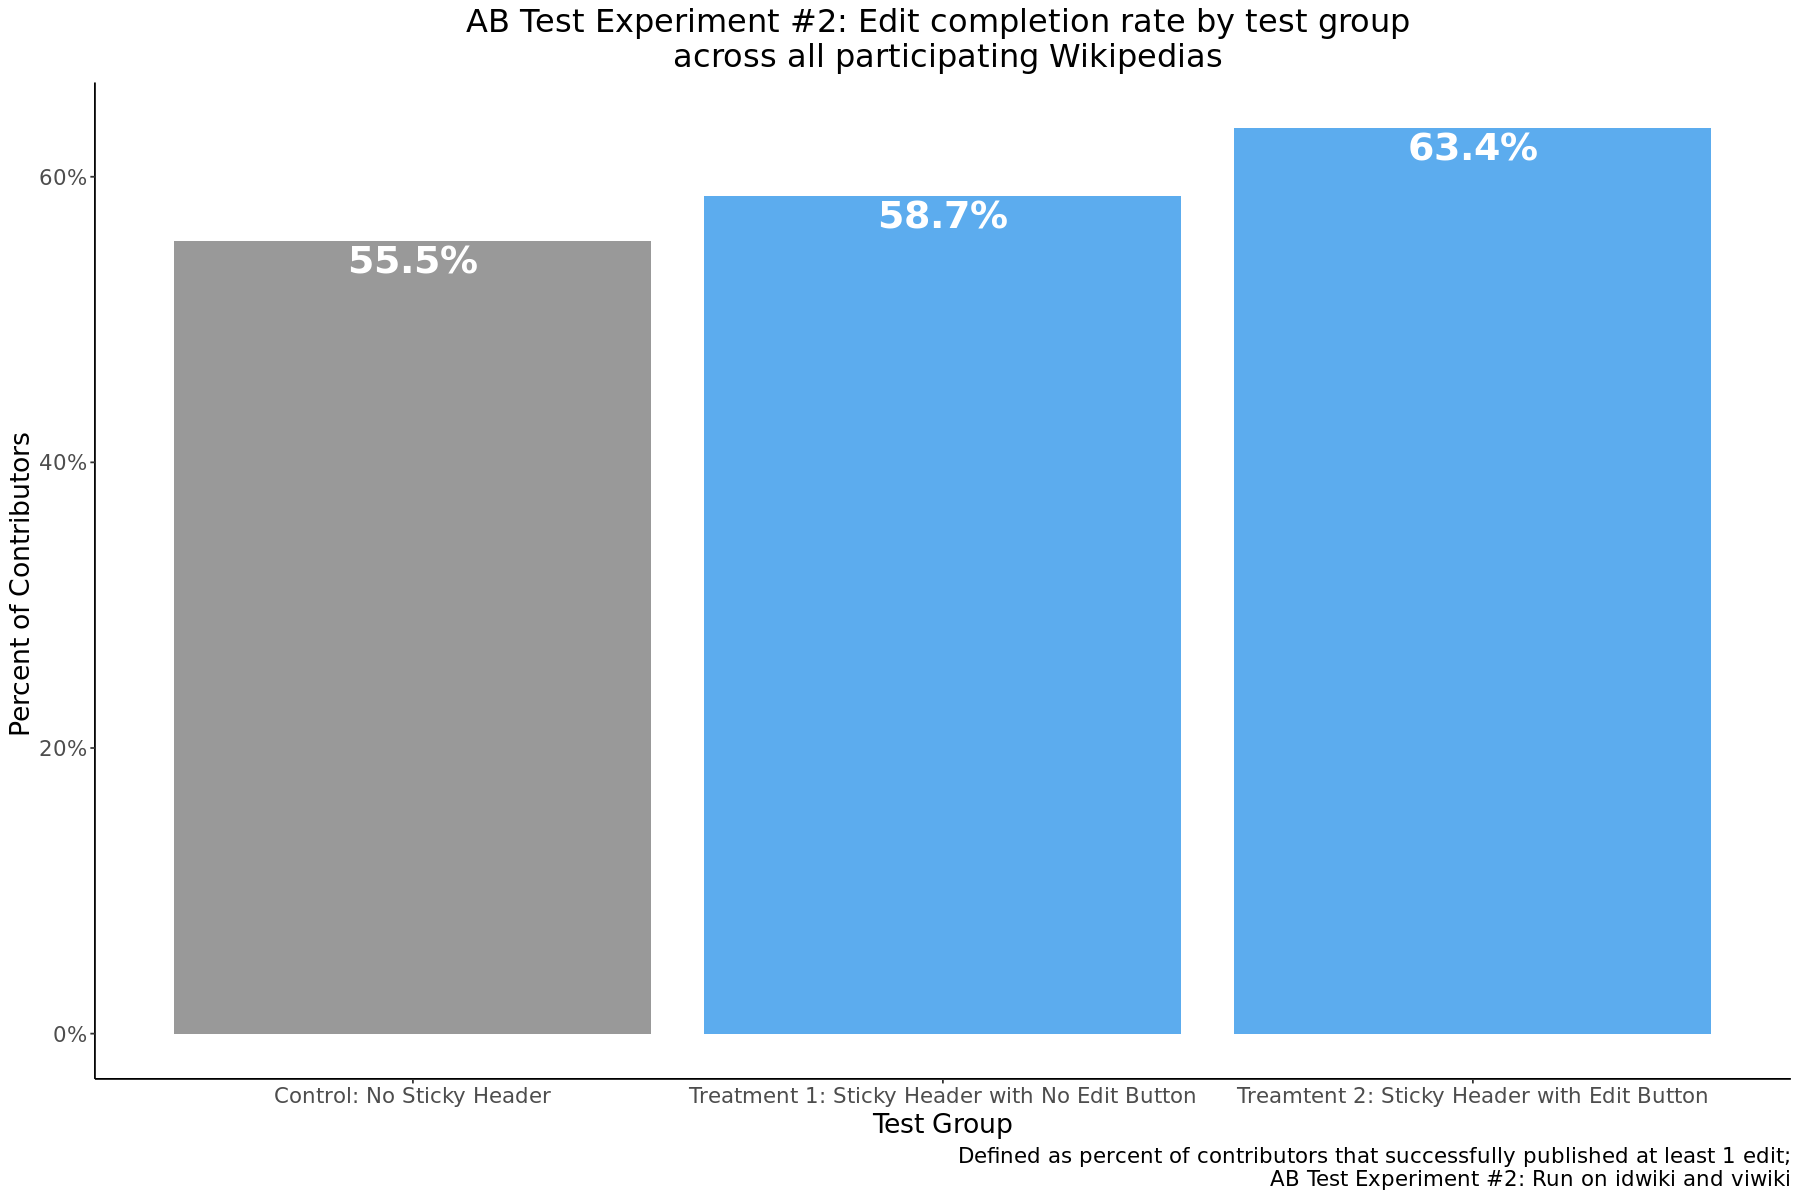

In [39]:
p <- edit_completion_rate_bytestgroup_group2  %>%
    ggplot(aes(x= test_group, y = n_users_completed / n_users, fill = test_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Control: No Sticky Header", "Treatment 1: Sticky Header with No Edit Button",
                                                            "Treamtent 2: Sticky Header with Edit Button")) +
    labs (y = "Percent of Contributors ",
          x = "Test Group",
          title = "AB Test Experiment #2: Edit completion rate by test group \n across all participating Wikipedias",
         caption = "Defined as percent of contributors that successfully published at least 1 edit;
AB Test Experiment #2: Run on idwiki and viwiki")  +
    scale_fill_manual(values= c("#999999", "steelblue2", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_completion_rate_bytestgroup_group2.png", p, width = 16, height = 8, units = "in", dpi = 300)

There was a slightly higher completion rate for both treatment groups (highest for the treatment gorup that had the sticky header with edit button) compared to the control group but 


### Overall Completion Rate Comparison across both AB Test Experiments

In [167]:
# combine edit completion data from both groups
edit_completion_rate_all <- rbind(edit_completion_rate_overall_group1, edit_completion_rate_byeditmethod_group2)

In [168]:
# Create table of completion rate
edit_completion_rate_all_table <- edit_completion_rate_all %>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment 1 and 2: Edit Completion Rates by Editing Initiation Type",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    editing_method = "Editing method",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Edit completion rate",
    experiment_group = "Experiment Version"
  ) %>%
  tab_row_group("AB Test Experiment #2: Control did not have sticky header", rows = experiment_group == 'ab_test_1') %>%
  tab_row_group("AB Test Experiment #1: Control had sticky header", rows = experiment_group == 'ab_test_2') %>%
  cols_hide(columns = c('experiment_group', 'n_users', 'n_users_completed'))  %>%
    gtsave(
    "edit_completion_rate_all_table.html", inline_css = TRUE) 

IRdisplay::display_html(data = edit_completion_rate_all_table,  file = "edit_completion_rate_all_table.html")

Warning message in min(rows_matched):
“no non-missing arguments to min; returning Inf”
Warning message in max(rows_matched):
“no non-missing arguments to max; returning -Inf”


<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment 1 and 2: Edit Completion Rates by Editing Initiation Type 
 
 
 across all participating Wikipedias 
 
 
 
 
 Editing method 
 Edit completion rate 
 
 
 
 
 AB Test Experiment #1: Control had sticky header 
 
 
 Existing editing button 
 59.2% 
 
 
 Sticky Header 
 63.2% 
 
 
 AB Test Experiment #2: Control did not have sticky header 
 
 
 Existing editing button 
 61.1% 
 
 
 Sticky Header 
 62.8%

### By Participating Wikipedia

#### Test group and Editing Initiation Type

In [40]:
edit_completion_rate_bywiki_group2  <-  edit_completion_rate_group2  %>%
    group_by(wiki, test_group, editing_method) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) %>%
     #determine credible intervals
    cbind(as.data.frame(binom:::binom.bayes(x = .$n_users_completed, n = .$n_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))


In [41]:
# Create table of completion rate by participating wikipedia
edit_completion_rate_bywiki_group2_table <- edit_completion_rate_bywiki_group2  %>%
  select(c(1,2,3,4,5,6, 13,14)) %>% #select needed rows
  gt() %>%
  tab_header(
    title = "AB Test Experiment #2: Edit completion rate by editing initiation type",
    subtitle = "at each participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    test_group = "Test Group",
    editing_method = "Editing initiation type",
    n_users = "Number of users attempted",
    n_users_completed = "Number of users completed",
    completion_rate = "Edit completion rate",
    lower  = "CI (lower bound)",
    upper = "CI (upper bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of contributors that attempted and published at least 1 new topic",
    locations = cells_column_labels(
      columns = 'completion_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run on 2 wikis, Control had no sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "edit_completion_rate_bywiki_group2_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_completion_rate_bywiki_group2_table, file = "edit_completion_rate_bywiki_group2_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #2: Edit completion rate by editing initiation type 1 
 
 
 at each participating Wikipedia 
 
 
 
 
 Wikipedia 
 Test Group 
 Editing initiation type 
 Number of users attempted 
 Number of users completed 
 Edit completion rate 2 
 CI (lower bound) 3 
 CI (upper bound) 3 
 
 
 
 
 Indonesian Wikipedia 
 No Sticky Header (Control) 
 Existing editing button 
 79 
 37 
 46.8% 
 0.36 
 0.58 
 
 
 Indonesian Wikipedia 
 Sticky Header with No Edit Button 
 Existing editing button 
 89 
 47 
 52.8% 
 0.43 
 0.63 
 
 
 Indonesian Wikipedia 
 Sticky Header with Edit Button 
 Existing editing button 
 81 
 47 
 58% 
 0.47 
 0.68 
 
 
 Indonesian Wikipedia 
 Sticky Header with Edit Button 
 Sticky Header 
 5 
 4 
 80% 
 0.44 
 1.00 
 
 
 Vietnamese Wikipedia 
 No Sticky Header (Control) 
 Existing editing button 
 103 
 64 
 62.1% 
 0.53 
 0.71 
 
 
 Vietnamese Wikipedia 
 Sticky Header with No Edit Button 
 Existing editing button 
 107 
 68 
 63.6% 
 0.54 
 0.72 
 
 
 Vietnamese Wikipedia 
 Sticky Header with Edit Button 
 Existing editing button 
 83 
 52 
 62.7% 
 0.52 
 0.73 
 
 
 Vietnamese Wikipedia 
 Sticky Header with Edit Button 
 Sticky Header 
 14 
 8 
 57.1% 
 0.33 
 0.80 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run on 2 wikis, Control had no sticky header
 
 
 
 
 2 
 
 
 Defined as percent of contributors that attempted and published at least 1 new topic
 
 
 
 
 3 
 
 
 95% credible intervals. There is a 95% probability that the parameter lies in this interval

#### Test group 

In [42]:
edit_completion_rate_bywiki_testgroup_group2  <-  edit_completion_rate_group2  %>%
    group_by(wiki, test_group) %>%
    summarise(n_users = n_distinct(user_id), 
              n_users_completed = sum(edit_success == 'Complete'), #user completed at least 1 edit
              completion_rate = paste0(round(n_users_completed / n_users  *100, 1), "%"),
              .groups = 'drop'
  ) %>%
     #determine credible intervals
    cbind(as.data.frame(binom:::binom.bayes(x = .$n_users_completed, n = .$n_users, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
           upper = round(upper, 2))

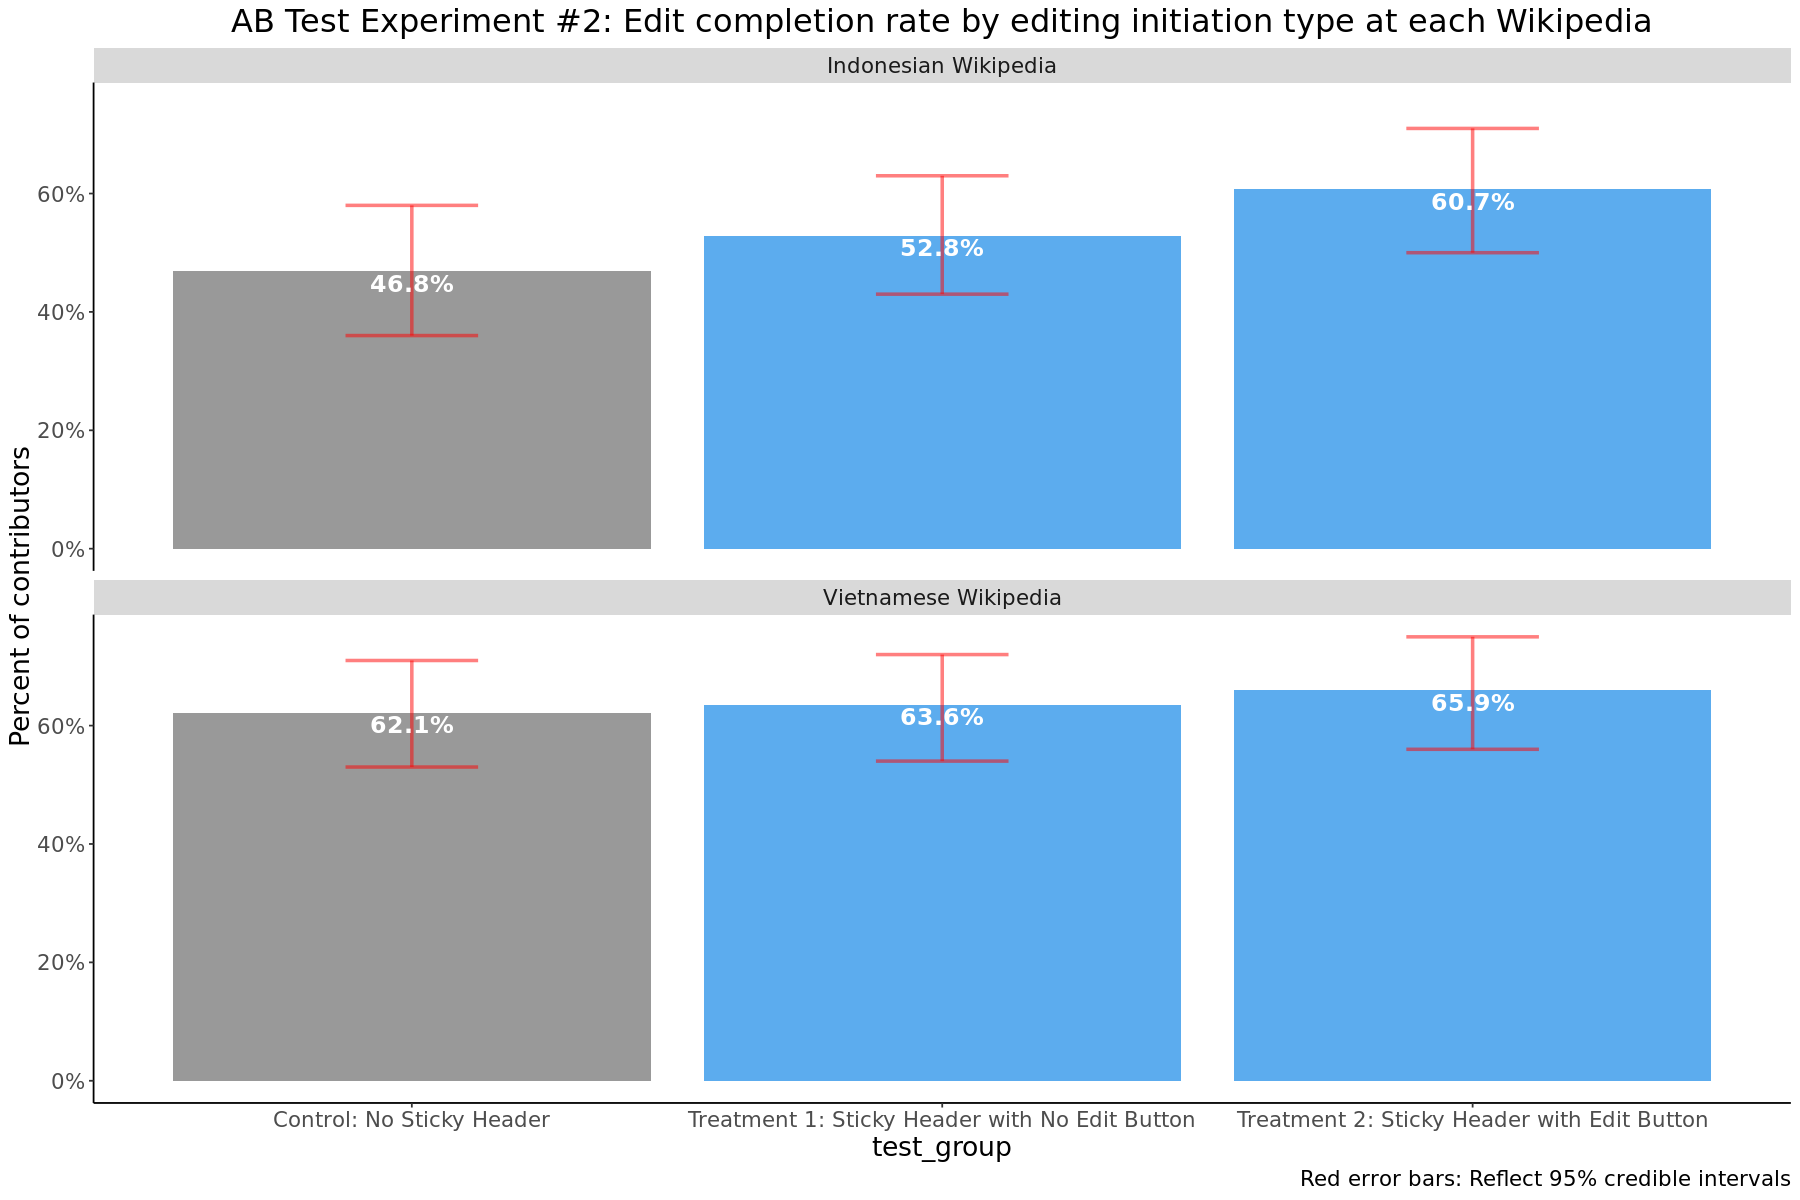

In [43]:
# Plot edit completion rates for each wiki  

dodge <- position_dodge(width=0.9)

p <- edit_completion_rate_bywiki_testgroup_group2   %>% 
    ggplot(aes(x= test_group, y = n_users_completed / n_users, fill = test_group)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(completion_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki, ncol = 1) +
    scale_x_discrete( labels = c("Control: No Sticky Header", "Treatment 1: Sticky Header with No Edit Button",
                                                            "Treatment 2: Sticky Header with Edit Button")) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "AB Test Experiment #2: Edit completion rate by editing initiation type at each Wikipedia",
         caption = "Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2",  "steelblue2"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="none",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_completion_rate_bywiki_group2 .png", p, width = 16, height = 8, units = "in", dpi = 300)

At each of the participating wikipedias, the treatment groups had higher edit completion rates compared to the control.

# By Experience Level (In Progress)

In [ ]:
    
# mutate(experience_group = 
#            case_when(experience_level < 100 ~ "under 100 edits",
#                      experience_level >= 100 & experience_level <= 500  ~ "between 100 and 500",
#                      experience_level > 500 ~ "over 500 edits")
#           )  %>%       

# Revert Rate

Related Question: Are people more or less likely to make destructive edits? 

To evaluate any disruption caused by the sticky header edit button, we reviewed the percent of edits that were reverted within 48 hours. We only reviewed edits made on the main namespace as the sticky header is not available on talk pages.

A couple notes:
* 48 hours is a common cutoff for reverts, as research suggests that, at least for the English Wikipedia, nearly all reverts take place within 48 hours. Source: Research: Revert. Mediawiki. https://meta.wikimedia.org/wiki/Research:Revert.
* Similarily to the edit completion rate analysis, bucketing data was not available for AB Test Experiment #1. Instead, we compared the revert rate for edits published using the sticky header to the revert rate for new topics made using existing editing afforfances available.

## AB Test Experiment 1 (Sticky header control): 

In [67]:
edit_reverts_group1 <-
  read.csv(
    file = 'Data/edit_reverts_group1.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [68]:

edit_reverts_group1$is_reverted <-
  factor(edit_reverts_group1$is_reverted,
         levels = c("reverted", "not-reverted"),
         labels = c("Reverted", "Not reverted"))

#reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
edit_reverts_group1$user_id <-
  as.character(paste(edit_reverts_group1$user_id, edit_reverts_group1$wiki,sep ="-" ))

#clarfiy wiki names
  edit_reverts_group1 <-   edit_reverts_group1 %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
         #clarfiy participating project names
      wiki == 'euwiki' ~ "Basque Wikipedia",
      wiki == 'frwiki' ~ "French Wikipedia",
      wiki == 'frwiktionary' ~ "French Wiktionary",
      wiki == 'hewiki' ~ 'Hebrew Wikipedia',
      wiki == 'fawiki' ~ 'Persian Wikipedia',
      wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
      wiki == 'bnwiki' ~ 'Bengali Wikipedia',
      wiki == 'dewikivoyage' ~ 'German Wikivoyage',
      wiki == 'kowiki' ~ 'Korean Wikipedia',
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia',  
      wiki == 'srwiki' ~ 'Serbian Wikipedia'   ,
      wiki == 'trwiki' ~ 'Turkish Wikipedia',
      wiki == 'vecwiki' ~ 'Venetian Wikipedia'  
    )
     )

### Overall by Editing Initiation Type

In [69]:
edit_reverted_group1 <- edit_reverts_group1 %>%
    filter(is_reverted == "Reverted")

In [75]:
edits_published_group1 <- sticky_header_edits_group1 %>%
    filter(edit_success == 'Complete') 

In [76]:
# join with edit attempt data to caluclate reverts by method 
edits_reverted_group1 <- merge(edits_published_group1 ,edit_reverted_group1,by= c("user_id", "wiki"), all.x=TRUE)


In [77]:
# look at prop of edits reverted by edit button type
edit_reverts_group1_bymethod <- edits_reverted_group1 %>%
    group_by(editing_method) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) *.20, 0), #sampling rate adjustment
              total_edits = n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2),
          experiment_group = 'ab_test_1') 
    


In [181]:
# Create table of completion rate
edit_reverts_group1_bymethod_table <- edit_reverts_group1_bymethod  %>%
  select(c(1,2,3,4, 11, 12)) %>% # select rows
  gt() %>%
  tab_header(
    title = "AB Test Experiment #1: Edit revert rate by editing initiation type",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    editing_method = "Editing initiation type",
    total_reverts = "Number of edits reverted",
    total_edits = "Number of edits completed",
    revert_rate = "Revert rate",
    lower = 'CI (lower bound)',
    upper = 'CI (upper bound)'
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of edits reverted within 48 hours of being published",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #1: Run on 15 wikis, Control had sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
    gtsave(
    "edit_reverts_group1_bymethod_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_reverts_group1_bymethod_table, file = "edit_reverts_group1_bymethod_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #1: Edit revert rate by editing initiation type 1 
 
 
 across all participating Wikipedias 
 
 
 
 
 Editing initiation type 
 Number of edits reverted 
 Number of edits completed 
 Revert rate 2 
 CI (lower bound) 
 CI (upper bound) 
 
 
 
 
 Existing editing button 
 21970 
 155853 
 14.1 % 
 0.14 
 0.14 
 
 
 Sticky Header 
 33 
 406 
 8.13 % 
 0.06 
 0.11 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #1: Run on 15 wikis, Control had sticky header
 
 
 
 
 2 
 
 
 Defined as percent of edits reverted within 48 hours of being published

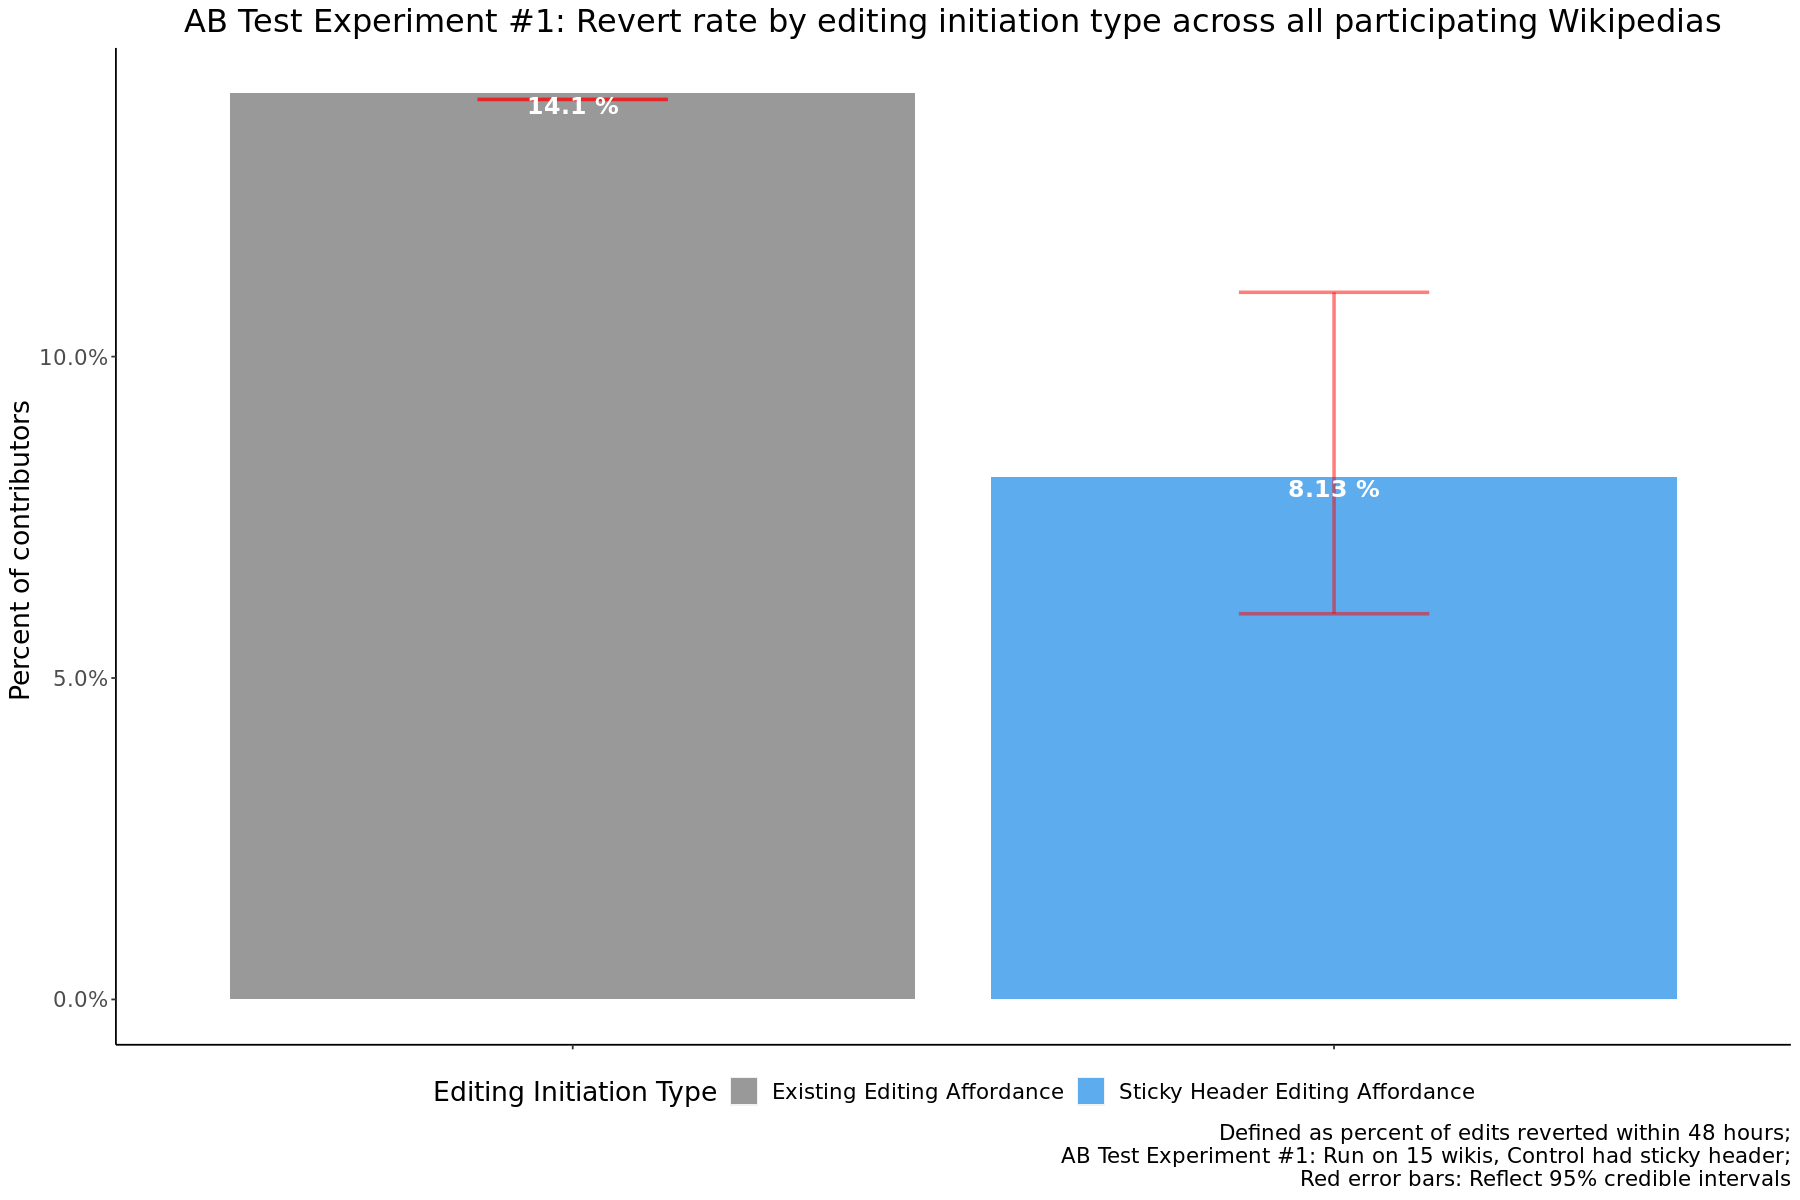

In [182]:
# Plot overall revert rates  

dodge <- position_dodge(width=0.9)

p <- edit_reverts_group1_bymethod  %>% 
    ggplot(aes(x= editing_method, y = total_reverts / total_edits, fill = editing_method)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "AB Test Experiment #1: Revert rate by editing initiation type across all participating Wikipedias",
         caption = "Defined as percent of edits reverted within 48 hours;
AB Test Experiment #1: Run on 15 wikis, Control had sticky header;
Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Initiation Type", labels = c("Existing Editing Affordance", "Sticky Header Editing Affordance"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 
      
p
ggsave("Figures/edit_reverts_group1_bymethod.png", p, width = 16, height = 8, units = "in", dpi = 300)

There was a 42% decrease in the revert rate of edits made using the sticking header editing affordance in AB experiment 1. Note: There is higher level of uncertainty in the revert rate for the sticky header as there were fewer edits made using this affordance compared to existing editing affordances . However, even with the larger range of possible revert rate values (as represented by larger red error bars on the chart above), the edits made with the sticky header appear are slightly less likely to be reverted than existing editing affordances.

### By Participating Wikipedia

In [183]:
# look at reverts by participating wikipedia
edit_reverts_group1_bywiki <- edits_reverted_group1 %>%
    group_by(wiki, editing_method) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) *.20, 0), #sampling rate adjustment
              total_edits = n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2)) 


In [184]:
# Create table of completion rate by participating wikipedia
edit_reverts_group1_bywiki_table <- edit_reverts_group1_bywiki %>%
  select(c(1,2,3,4,5,12,13)) %>% #select needed rows
  gt() %>%
  tab_header(
    title = "AB Test Experiment #1: Revert rate by editing initiation type",
    subtitle = "at each participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    editing_method = "Editing initiation type",
    total_reverts = "Number of reverts",
    total_edits = "Number of edits",
    revert_rate = "Revert rate",
    lower = "CI (lower bound)",
    upper = "CI (upper bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of edits reverted within 48 hours",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #1: Run on 15 wikis, Control had sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "edit_reverts_group1_bywiki_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_reverts_group1_bywiki_table, file = "edit_reverts_group1_bywiki_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #1: Revert rate by editing initiation type 1 
 
 
 at each participating Wikipedia 
 
 
 
 
 Wikipedia 
 Editing initiation type 
 Number of reverts 
 Number of edits 
 Revert rate 2 
 CI (lower bound) 3 
 CI (upper bound) 3 
 
 
 
 
 Basque Wikipedia 
 Existing editing button 
 93 
 769 
 12.09 % 
 0.10 
 0.14 
 
 
 French Wikipedia 
 Existing editing button 
 12790 
 93912 
 13.62 % 
 0.13 
 0.14 
 
 
 French Wikipedia 
 Sticky Header 
 19 
 240 
 7.92 % 
 0.05 
 0.12 
 
 
 French Wiktionary 
 Existing editing button 
 179 
 2500 
 7.16 % 
 0.06 
 0.08 
 
 
 Hebrew Wikipedia 
 Existing editing button 
 3608 
 23011 
 15.68 % 
 0.15 
 0.16 
 
 
 Hebrew Wikipedia 
 Sticky Header 
 6 
 62 
 9.68 % 
 0.04 
 0.18 
 
 
 Korean Wikipedia 
 Existing editing button 
 1793 
 12616 
 14.21 % 
 0.14 
 0.15 
 
 
 Korean Wikipedia 
 Sticky Header 
 0 
 7 
 0 % 
 0.00 
 0.23 
 
 
 Persian Wikipedia 
 Existing editing button 
 1485 
 8845 
 16.79 % 
 0.16 
 0.18 
 
 
 Persian Wikipedia 
 Sticky Header 
 3 
 17 
 17.65 % 
 0.04 
 0.37 
 
 
 Portuguese Wikipedia 
 Existing editing button 
 1068 
 8087 
 13.21 % 
 0.12 
 0.14 
 
 
 Portuguese Wikipedia 
 Sticky Header 
 4 
 60 
 6.67 % 
 0.02 
 0.14 
 
 
 Portuguese Wikiversity 
 Existing editing button 
 0 
 27 
 0 % 
 0.00 
 0.07 
 
 
 Portuguese Wikiversity 
 Sticky Header 
 0 
 2 
 0 % 
 0.00 
 0.57 
 
 
 Serbian Wikipedia 
 Existing editing button 
 243 
 1749 
 13.89 % 
 0.12 
 0.16 
 
 
 Serbian Wikipedia 
 Sticky Header 
 0 
 3 
 0 % 
 0.00 
 0.44 
 
 
 Turkish Wikipedia 
 Existing editing button 
 709 
 4304 
 16.47 % 
 0.15 
 0.18 
 
 
 Turkish Wikipedia 
 Sticky Header 
 2 
 15 
 13.33 % 
 0.01 
 0.33 
 
 
 Venetian Wikipedia 
 Existing editing button 
 5 
 33 
 15.15 % 
 0.05 
 0.28 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #1: Run on 15 wikis, Control had sticky header
 
 
 
 
 2 
 
 
 Defined as percent of edits reverted within 48 hours
 
 
 
 
 3 
 
 
 95% credible intervals. There is a 95% probability that the parameter lies in this interval

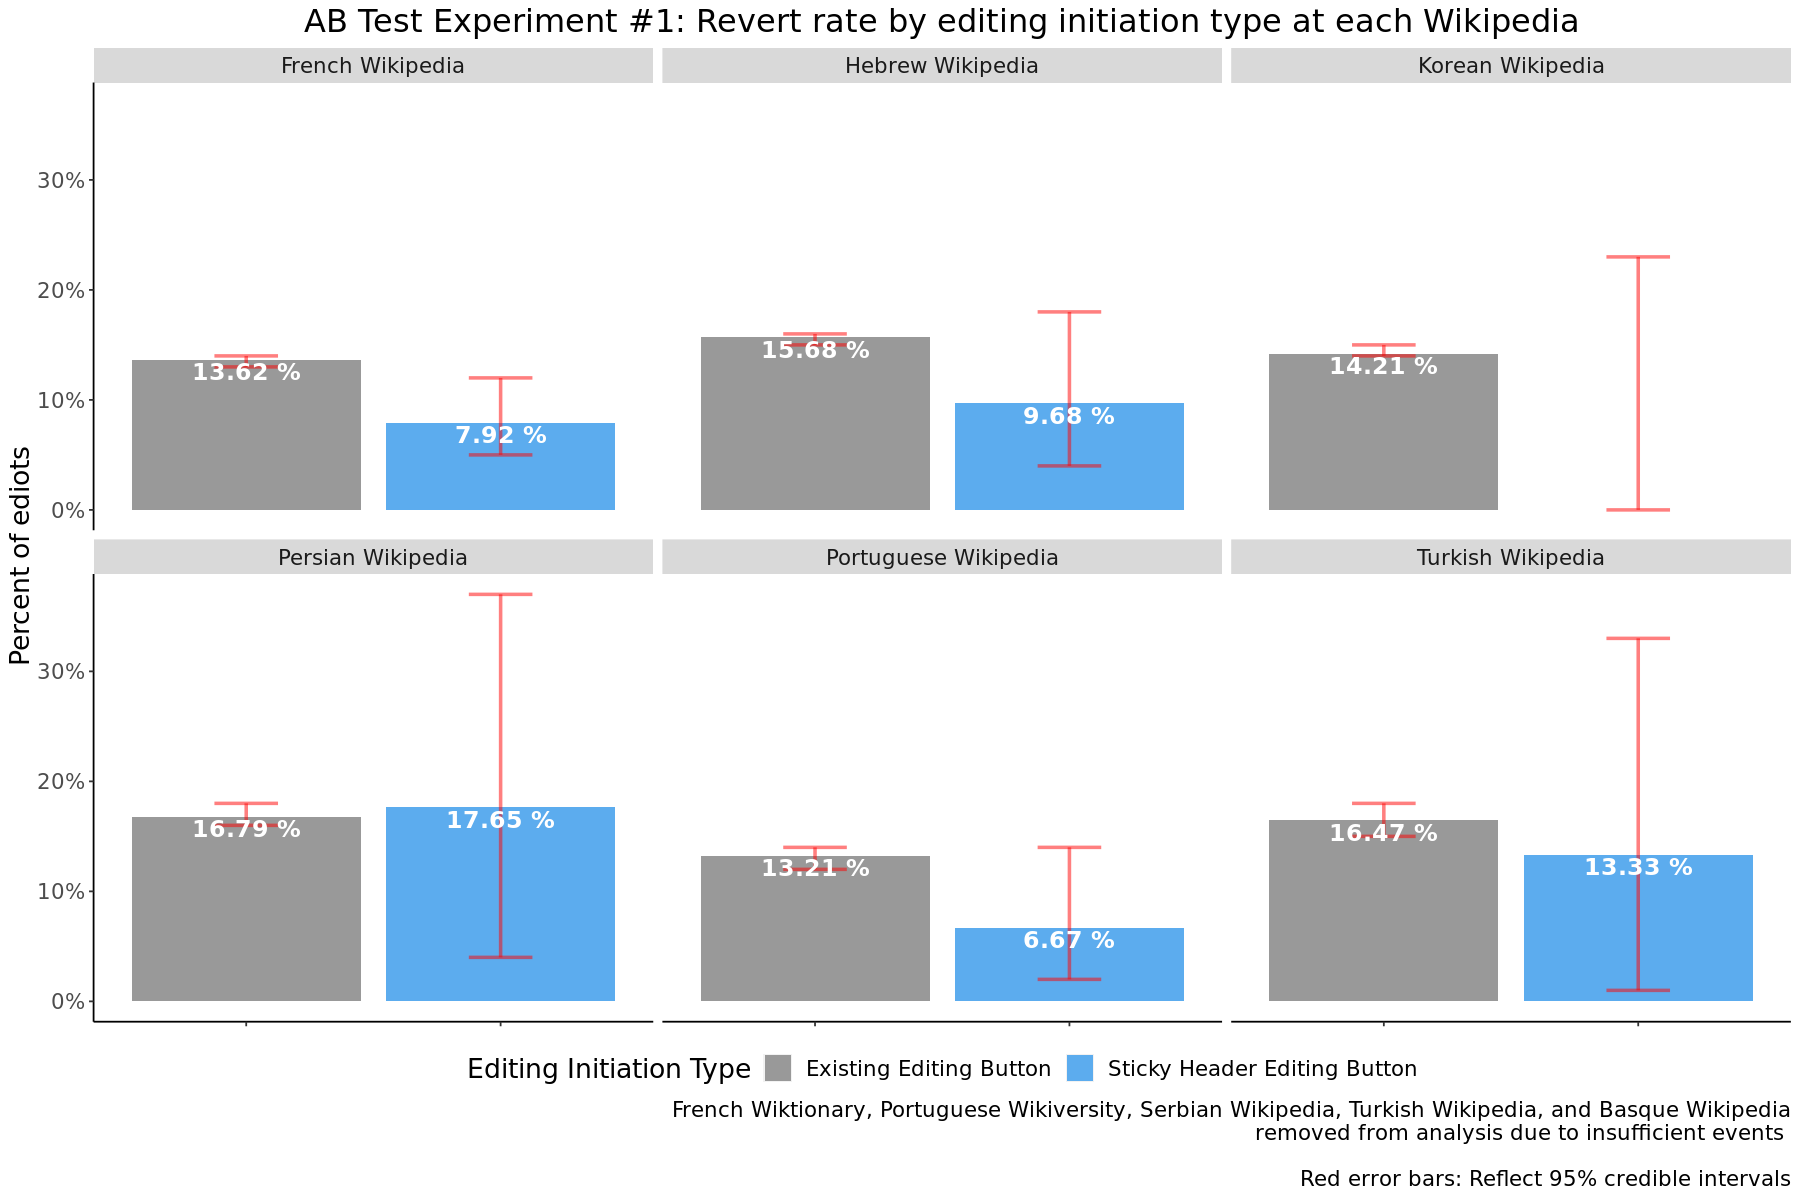

In [186]:
# plot revert rates by wiki
p <- edit_reverts_group1_bywiki %>%
    filter(!(wiki %in% c('French Wiktionary', 'Portuguese Wikiversity', 'Serbian Wikipedia', 'Venetian Wikipedia', 'Basque Wikipedia'))) %>% # remove wikis where there are under 10 events as we 
    ggplot(aes(x= editing_method, y = total_reverts / total_edits, fill = editing_method)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of ediots ",
          title = "AB Test Experiment #1: Revert rate by editing initiation type at each Wikipedia",
         caption = "French Wiktionary, Portuguese Wikiversity, Serbian Wikipedia, Turkish Wikipedia, and Basque Wikipedia
removed from analysis due to insufficient events \n
         Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2"), name = "Editing Initiation Type", labels = c("Existing Editing Button", "Sticky Header Editing Button"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_reverts_group1_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Results vary on a per Wikipedia basis.

As with edit completion rates by wiki, is a high level of uncertainty around many of these per Wikipedia revert rate values due to the smaller number of edits recorded on a per Wikipedia basis, especially for smaller sized Wikipedias (as represented by larger red error bars on the chart above). We can be more confident in the identified revert rate values for Wikipedias with more data and smaller error bars such as French, Portuguese, and Hebrew Wikipedia, which all indicate a lower revert rate for edits made with the new sticky header editing affordance.

## AB Test Experiment #2: Sticky Header No Control

In [54]:
# Load data

edit_reverts_group2_v2 <-
  read.csv(
    file = 'Data/edit_reverts_group2_v2.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [55]:
edit_reverts_group2_v2$is_reverted <-
  factor(edit_reverts_group2_v2$is_reverted,
         levels = c("reverted", "not-reverted"),
         labels = c("Reverted", "Not reverted"))

#reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
edit_reverts_group2_v2$user_id <-
  as.character(paste(edit_reverts_group2_v2$user_id, edit_reverts_group2_v2$wiki,sep ="-" ))

#clarfiy wiki names
   edit_reverts_group2_v2 <-  edit_reverts_group2_v2 %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'idwiki' ~ "Indonesian Wikipedia",
      wiki == 'viwiki' ~ "Vietnamese Wikipedia"    
    )
  )

### Overall by Editing Initiation Type and Test Group(Method #2)

In [56]:
edit_reverted_group2_v2 <- edit_reverts_group2_v2 %>%
    filter(is_reverted == "Reverted")

In [57]:
edits_published_group2 <- sticky_header_edits_group2 %>%
    filter(edit_success == 'Complete') 

In [58]:
# join with edit attempt data to caluclate reverts by method 
edits_reverted_group2_v2 <- merge(edits_published_group2 ,edit_reverted_group2_v2,by= c("user_id", "wiki"), all.x=TRUE)


In [60]:
# look at prop of edits reverted by edit button type
edit_reverts_group2_bymethod_v2 <- edits_reverted_group2_v2 %>%
    group_by(test_group, editing_method) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) * 0.20, 0) , #sampling rate adjustment
              total_edits =  n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2))


In [61]:
edit_reverts_group2_bytestgroup_table <- edit_reverts_group2_bymethod_v2  %>%
  select(c(1,2,3,4, 5, 12,13))  %>% #remove unneeded rows
  gt()  %>%
  tab_header(
    title = "AB Test Experiment #2: Revert rates by editing initiation type and test group",
      subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    test_group = "Test Group",
    editing_method = "Editing method",
    total_reverts = "Number of new topics reverted",
    total_edits = "Number of new topics published",
    revert_rate = "Revert rate",
    lower = "CI (Lower Bound)",
    upper = "CI (Upper Bound)"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of edits reverted within 48 hours.",
    locations = cells_column_labels(
      columns = 'revert_rate'
    ) ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run on 2 wikis, Control had no sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )
  ) %>%
 cols_hide(columns = c('total_reverts', 'total_edits', 'lower', 'upper'))  %>%
    gtsave(
    "edit_reverts_group2_bytestgroup_table.html", inline_css = TRUE)

IRdisplay::display_html(file = "edit_reverts_group2_bytestgroup_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #2: Revert rates by editing initiation type and test group 1 
 
 
 across all participating Wikipedias 
 
 
 
 
 Test Group 
 Editing method 
 Revert rate 2 
 
 
 
 
 No Sticky Header (Control) 
 Existing editing button 
 9.8 % 
 
 
 Sticky Header with No Edit Button 
 Existing editing button 
 11.47 % 
 
 
 Sticky Header with Edit Button 
 Existing editing button 
 7.72 % 
 
 
 Sticky Header with Edit Button 
 Sticky Header 
 6.25 % 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run on 2 wikis, Control had no sticky header
 
 
 
 
 2 
 
 
 Defined as percent of edits reverted within 48 hours.

### Overall by Test Group

In [62]:
# look at prop of edits reverted by test group
edit_reverts_group2_bygroup <- edits_reverted_group2_v2 %>%
    group_by(test_group) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) * 0.20, 0) , #sampling rate adjustment
              total_edits =  n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2))


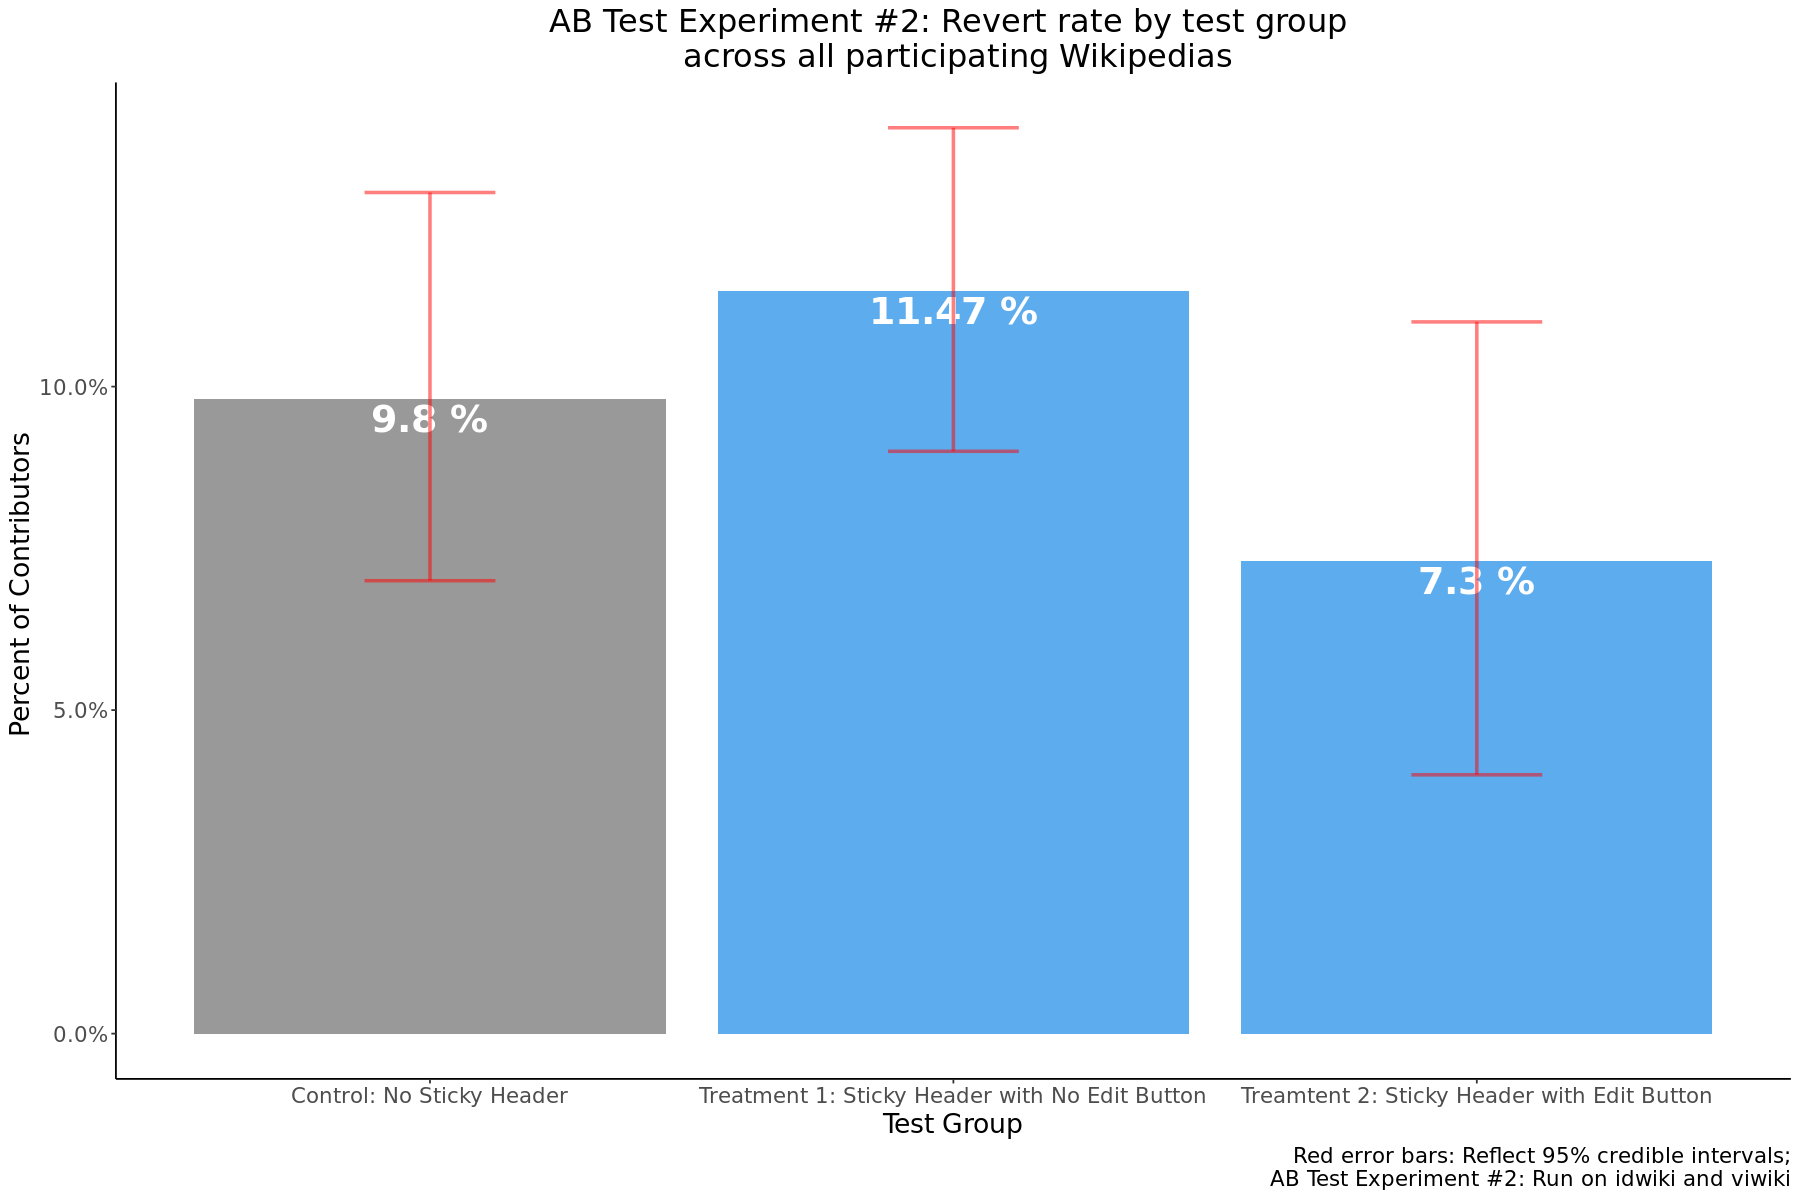

In [63]:
dodge <- position_dodge(width=0.9)

p <- edit_reverts_group2_bygroup %>%
    ggplot(aes(x= test_group, y = total_reverts / total_edits, fill = test_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 8, color = "white") +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Control: No Sticky Header", "Treatment 1: Sticky Header with No Edit Button",
                                                            "Treamtent 2: Sticky Header with Edit Button")) +
    labs (y = "Percent of Contributors ",
          x = "Test Group",
          title = "AB Test Experiment #2: Revert rate by test group \n across all participating Wikipedias",
         caption = "Red error bars: Reflect 95% credible intervals;
AB Test Experiment #2: Run on idwiki and viwiki")  +
    scale_fill_manual(values= c("#999999", "steelblue2", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_reverts_group2_bygroup.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observerd the lowest revert rate fro Treatment Group 2: Sticky header with edit button; however, there is a significant margin of error identified across all three groups. Given the observed values and margin of error, we are unable to confirm any statitical difference in revert rates across the three test groups in AB Test Experiment #2. 

### Overall Revert Rate Comparison across both AB Test Experiments

In [83]:
# look at prop of edits reverted by test group
edit_reverts_group2_bymethod <- edits_reverted_group2_v2 %>%
    group_by(editing_method) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) * 0.20, 0) , #sampling rate adjustment
              total_edits =  n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2),
           experiment_group = 'ab_test_2')



In [86]:
# combine edit completion data from both groups
edit_revert_rate_all <- rbind(edit_reverts_group1_bymethod, edit_reverts_group2_bymethod)

In [88]:
# Create table of completion rate
edit_revert_rate_all_table <- edit_revert_rate_all %>%
  select(c(1,2,3,4,11,12,14)) %>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment 1 and 2: Revert Rates by Editing Initiation Type",
    subtitle = "across all participating Wikipedias"
  )  %>%
  cols_label(
    editing_method = "Editing method",
    total_reverts = "Number of reverts",
    total_edits = "Number of edits",
    revert_rate = "Revert rate",
    lower = "CI (lower bound)",
    upper = "CI (upper bound)",
    experiment_group = "Experiment Group"
  ) %>%
  # tab_footnote(
  #   footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
  #   locations = cells_column_labels(
  #     columns = c('lower', 'upper')
  #   )) %>%
  tab_row_group("AB Test Experiment #2: Control did not have sticky header", rows = experiment_group == 'ab_test_2') %>%
  tab_row_group("AB Test Experiment #1: Control had sticky header", rows = experiment_group == 'ab_test_1') %>%
  cols_hide(columns = c('experiment_group', 'total_reverts', 'total_edits'))  %>%
    gtsave(
    "edit_revert_rate_all_table.html", inline_css = TRUE) 

IRdisplay::display_html(data = edit_revert_rate_all_table,  file = "edit_revert_rate_all_table.html")

Warning message in min(rows_matched):
“no non-missing arguments to min; returning Inf”
Warning message in max(rows_matched):
“no non-missing arguments to max; returning -Inf”


<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment 1 and 2: Revert Rates by Editing Initiation Type 
 
 
 across all participating Wikipedias 
 
 
 
 
 Editing method 
 Revert rate 
 CI (lower bound) 
 CI (upper bound) 
 
 
 
 
 AB Test Experiment #1: Control had sticky header 
 
 
 Existing editing button 
 14.1 % 
 0.14 
 0.14 
 
 
 Sticky Header 
 8.13 % 
 0.06 
 0.11 
 
 
 AB Test Experiment #2: Control did not have sticky header 
 
 
 Existing editing button 
 10.29 % 
 0.09 
 0.12 
 
 
 Sticky Header 
 6.25 % 
 0.00 
 0.22

We observed a decrease in revert rates for edits published across both AB Test experiments.

As mentioned above, there is higher level of uncertainty in the revert rate for the sticky header as there were fewer edits made using this affordance compared to existing editing affordances . However, even with the larger range of possible revert rate values (as represented by the lower and upper Confidence Interval (CI) bounds in the chart, there does not appear to be any statistically signficant difference any revert rates caused by the sticky header. 

### By Participating Wikipedia

#### Test Group and Editing Initiation Type

In [217]:
# look at prop of edits reverted by edit button type
edit_reverts_group2_bywiki <- edits_reverted_group2_v2 %>%
    group_by(wiki, test_group) %>%
    summarise(total_reverts = round(n_distinct(edit_attempt_id[is_reverted == "Reverted"]) * 0.20, 0) , #sampling rate adjustment
              total_edits = n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2))


In [218]:
# Create table of revert rate by participating wikipedia
edit_reverts_group2_bywiki_table <- edit_reverts_group2_bywiki %>%
  select(c(1,2,3,4,5,12,13)) %>% #select needed rows
  gt() %>%
  tab_header(
    title = "AB Test Experiment #2: Revert rate by editing initiation type",
    subtitle = "at each participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    test_group = "Test Group",
    total_reverts = "Number of reverts",
    total_edits = "Number of edits",
    revert_rate = "Revert rate"
  ) %>%
  tab_footnote(
    footnote = "Defined as percent of edits reverted within 48 hours",
    locations = cells_column_labels(
      columns = 'revert_rate'
    )
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run on 2 wikis, Control did not have sticky header",
    locations = cells_title(
      groups = "title")
    ) %>%
  tab_footnote(
    footnote = "95% credible intervals. There is a 95% probability that the parameter lies in this interval",
    locations = cells_column_labels(
      columns = c('lower', 'upper')
    )) %>%
    gtsave(
    "edit_reverts_group2_bywiki_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_reverts_group2_bywiki_table, file = "edit_reverts_group2_bywiki_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #2: Revert rate by editing initiation type 1 
 
 
 at each participating Wikipedia 
 
 
 
 
 Wikipedia 
 Test Group 
 Number of reverts 
 Number of edits 
 Revert rate 2 
 lower 3 
 upper 3 
 
 
 
 
 Indonesian Wikipedia 
 No Sticky Header (Control) 
 3 
 83 
 3.61 % 
 0.01 
 0.08 
 
 
 Indonesian Wikipedia 
 Sticy Header with No Edit Button 
 5 
 96 
 5.21 % 
 0.02 
 0.10 
 
 
 Indonesian Wikipedia 
 Sticky Header with Edit Button 
 15 
 164 
 9.15 % 
 0.05 
 0.14 
 
 
 Vietnamese Wikipedia 
 No Sticky Header (Control) 
 27 
 223 
 12.11 % 
 0.08 
 0.17 
 
 
 Vietnamese Wikipedia 
 Sticy Header with No Edit Button 
 74 
 584 
 12.67 % 
 0.10 
 0.15 
 
 
 Vietnamese Wikipedia 
 Sticky Header with Edit Button 
 6 
 110 
 5.45 % 
 0.02 
 0.10 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run on 2 wikis, Control did not have sticky header
 
 
 
 
 2 
 
 
 Defined as percent of edits reverted within 48 hours
 
 
 
 
 3 
 
 
 95% credible intervals. There is a 95% probability that the parameter lies in this interval

#### Test Group

In [219]:
# look at prop of edits reverted by edit button type
edit_reverts_group2_bywiki <- edits_reverted_group2_v2 %>%
    group_by(wiki, test_group) %>%
    summarise(total_reverts = n_distinct(edit_attempt_id[is_reverted == "Reverted"]) * 0.20 , #sampling rate adjustment
              total_edits = n_distinct(edit_attempt_id),
              revert_rate =paste(round(total_reverts/total_edits * 100, 2), '%'), .groups = 'drop') %>%
   cbind(as.data.frame(binom:::binom.bayes(x = .$total_reverts, n = .$total_edits, conf.level = 0.95, tol = 1e-10))) %>%
    mutate(lower = round(lower,2), 
          upper = round(upper, 2))


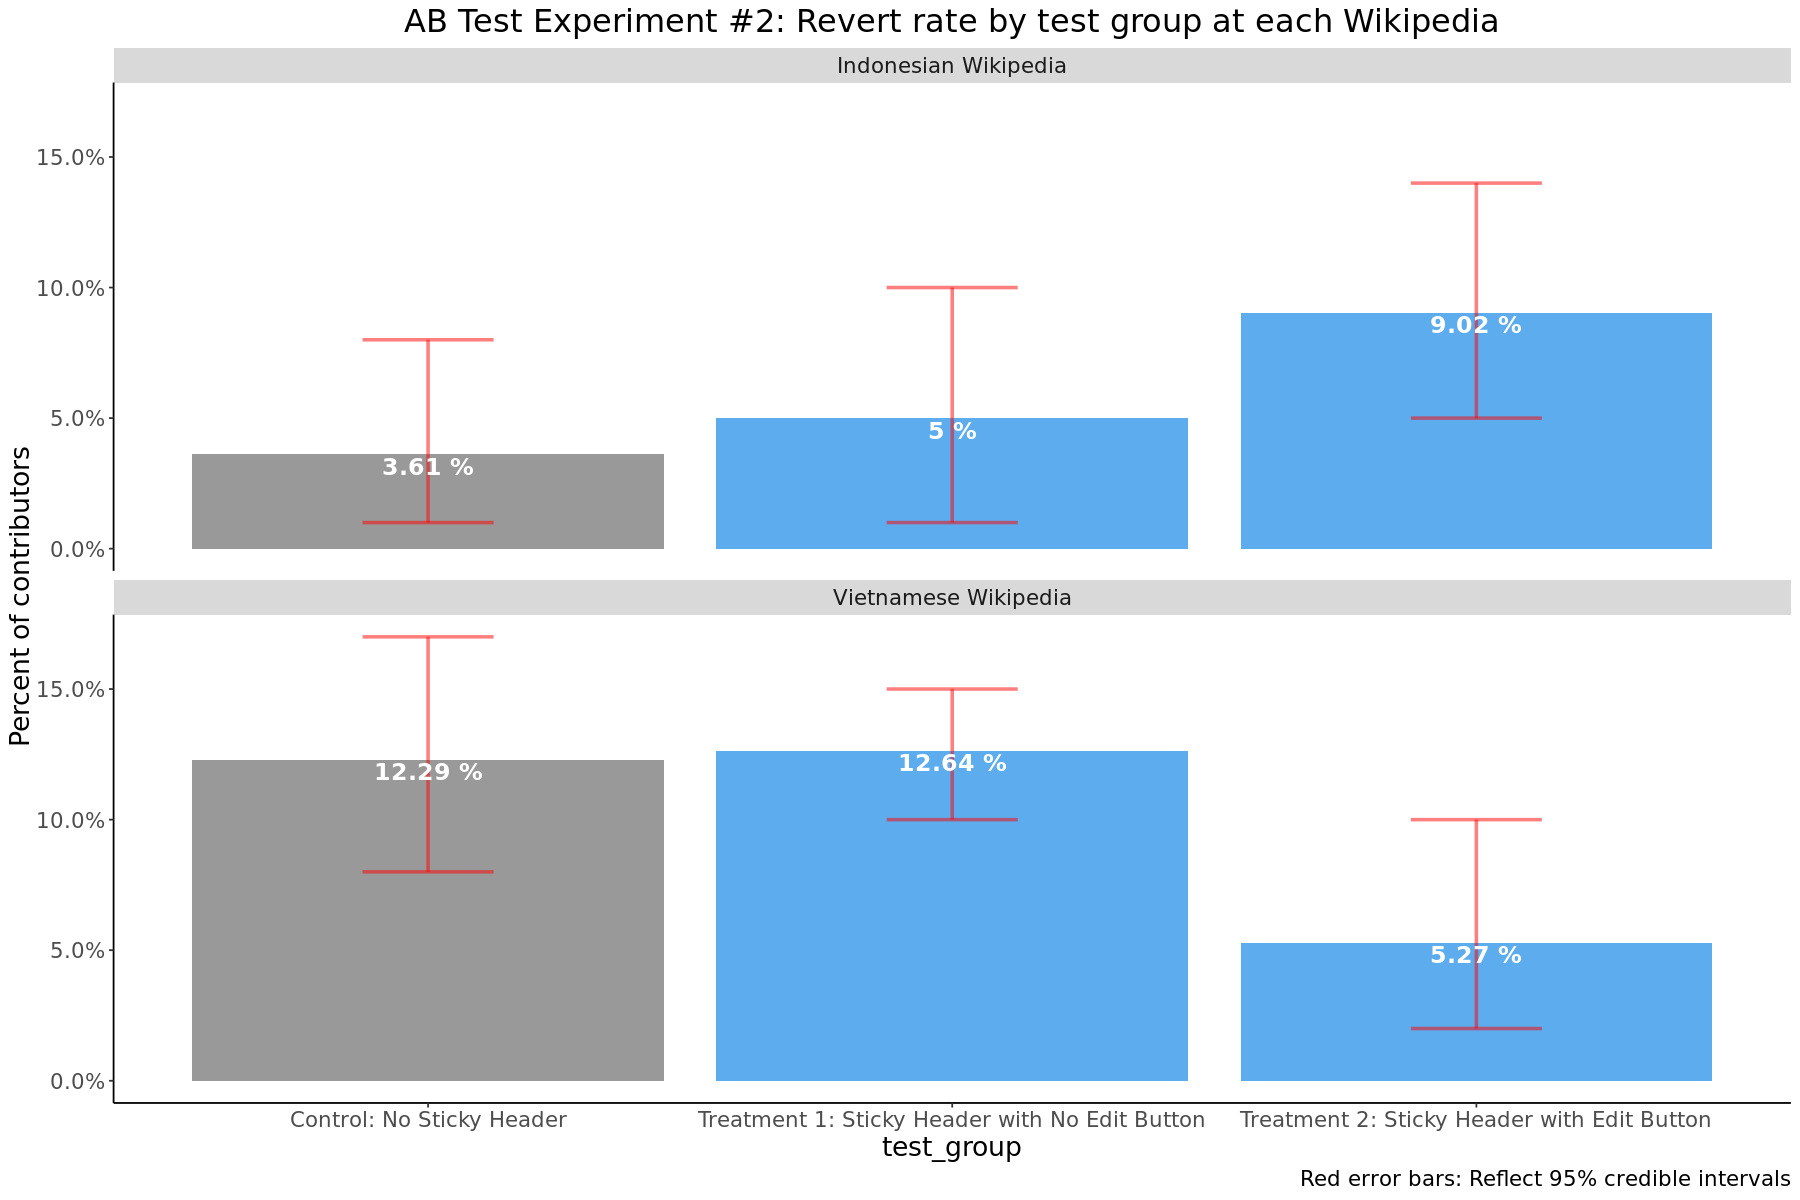

In [220]:
# Plot revert rates for each test group  

dodge <- position_dodge(width=0.9)

p <- edit_reverts_group2_bywiki  %>% 
    ggplot(aes(x= test_group, y = total_reverts / total_edits, fill = test_group)) +
    geom_col(position = 'dodge') +
    geom_errorbar(aes(ymin = lower, ymax = upper), color = 'red', size = 1, alpha = 0.5, position = dodge, width = 0.25) +
    geom_text(aes(label = paste(revert_rate), fontface=2), vjust=1.2, size = 5, color = "white") +
    facet_wrap(~ wiki, ncol = 1) +
    scale_x_discrete( labels = c("Control: No Sticky Header", "Treatment 1: Sticky Header with No Edit Button",
                                                            "Treatment 2: Sticky Header with Edit Button")) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of contributors ",
          title = "AB Test Experiment #2: Revert rate by test group at each Wikipedia",
         caption = "Red error bars: Reflect 95% credible intervals")  +
    scale_fill_manual(values= c("#999999", "steelblue2",  "steelblue2"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="none",
        axis.line = element_line(colour = "black")) 

      
p
ggsave("Figures/edit_reverts_group2_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed differing trends for Indonesian and Vietnamese Wikipedia. Indonesian Wikipedia had a slightly higher revert rate for the treatment groups while Vietnamese Wikipedia had a slightly lower revert rate.

Given the credible interval range (as indicated by the red error bars), these differences in revert rates do not appear to be statistically signficiant. 

# Edit Engagement

Related Question: Does the presence of the new editing affordance within the sticky header increase peoples' awareness of their ability to edit the content they are consuming?

Data Notes/Issues: 
* This analysis only looks at events logged in AB Test Experiment #2. We are unable to accurately calculate this metrics for AB Test Experiment #1 as desktop view data was removed by the time of the analysis start.

* We obtained data on pageviews from the desktopwebuiactionstracking schema to determine sessions in the AB test that viewed a desktop page d and initiated an edit session by clicking an available editing affordance. 

* For the purpose of this analysis, we reviewed activity within each test group, across all editing methods, to determine if the presence of the editing affordance within the sticky header led to increased awareness of the user to edit using any of the available editing methods. 


## AB Test Experiment #2

In [44]:
# load all views
desktop_views <-
  read.csv(
    file = 'Data/edit_attempts_bytestgroup.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 

In [45]:
#clarfiy wiki names
  desktop_views <-  desktop_views %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'idwiki' ~ "Indonesian Wikipedia",
      wiki == 'viwiki' ~ "Vietnamese Wikipedia"    
    ))


desktop_views$test_group <-
  factor(
    desktop_views$test_group,
    levels = c("noStickyHeaderControl", "stickyHeaderNoEditButtonTreatment1", "stickyHeaderEditButtonTreatment2"),
    labels = c("No Sticky Header (Control) ", "Sticky Header with No Edit Button", "Sticky Header with Edit Button")
  )

### Overall by Test Group


In [46]:
# overall  
prop_edit_clicks_overall <- desktop_views %>%
    group_by(wiki, test_group) %>%
    summarise(n_sessions = n_distinct(view_session), 
              n_pages = n_distinct(page_token),
              n_sessions_with_editclicks = n_distinct(view_session[session_click == '1']))


In [47]:
ab_experiment_group2_published_edits <- sticky_header_edits_group2 %>%
   filter(is_oversample == 'false') %>%  # remove oversampled DT events
  group_by(wiki, test_group) %>%
  summarise(users = n_distinct(user_id),
        edit_attempts = ifelse(wiki == 'Indonesian Wikipedia', round((n_distinct(edit_attempt_id)/0.0625)*0.20, 0),
                               n_distinct(edit_attempt_id)),  #sampling rate adjustment for idwiki (sampled at different rate)
           published_edits = ifelse(wiki == 'Indonesian Wikipedia', round((n_distinct(edit_attempt_id[edit_success == 'Complete'])/0.0625)*0.20, 0),
                               n_distinct(edit_attempt_id[edit_success == 'Complete']))) %>%
        distinct()


In [48]:
ab_experiment_group2_published_overall <- ab_experiment_group2_published_edits  %>%
    group_by(wiki, test_group) %>%
    summarise(edit_attempts = sum(edit_attempts),
        published_edits = sum(published_edits))


In [49]:
edit_engagement_group2_bywiki <- prop_edit_clicks_overall %>%
    left_join(ab_experiment_group2_published_overall, by = c("wiki", "test_group")) %>%
    mutate(prop_engagement_bypageview = paste0(round(edit_attempts/n_pages * 100,2),"%"),
           prop_engagement_bysession = paste0(round(edit_attempts/n_sessions * 100,2),"%")
          )


In [50]:
# join with engagement table
edit_engagement_group2_overall <- edit_engagement_group2_bywiki %>% 
     group_by(test_group) %>%
     summarise(n_sessions = sum(n_sessions),
               n_pages = sum(n_pages),
                edit_attempts = sum(edit_attempts),
               published_edits = sum(published_edits),
         prop_engagement_bypageview = paste0(round(edit_attempts/n_pages * 100,2),"%"),
              prop_engagement_bysession = paste0(round(edit_attempts/n_sessions * 100,2),"%"))



In [51]:
# Create table of engagement overall
edit_engagement_group2_table <- edit_engagement_group2_overall %>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment #2: Edit engagement by test group"
  )  %>%
  cols_label(
    test_group = "Test Group",
    n_sessions = "Number of unique sessions",
    n_pages = "Number of pageviews",
    edit_attempts = "Number of edit attempts",
    published_edits = "Number of published edits",
    prop_engagement_bypageview  = "Edit engagement rate by pageview",
     prop_engagement_bysession  = "Edit engagement rate by session", 
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run from 16 August 2022 through 1 September 2022 on Indonesian and Vietnamese Wikipedia",
    locations = cells_title(
      groups = "title")
    )  %>%
  tab_footnote(
    footnote = "Defined as percent of pageviews that result in edit attempt",
    locations = cells_column_labels(
      columns = 'prop_engagement_bypageview'
    )
  ) %>%
tab_footnote(
    footnote = "Defined as percent of unqiue sessions that result in at least 1 edit attempt",
    locations = cells_column_labels(
      columns = 'prop_engagement_bysession'
    )
  ) %>%
    gtsave(
    "edit_engagement_group2_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_engagement_group2_table, file = "edit_engagement_group2_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #2: Edit engagement by test group 1 
 
 
 
 
 
 
 
 Test Group 
 Number of unique sessions 
 Number of pageviews 
 Number of edit attempts 
 Number of published edits 
 Edit engagement rate by pageview 2 
 Edit engagement rate by session 3 
 
 
 
 
 No Sticky Header (Control) 
 5154 
 73778 
 629 
 354 
 0.85% 
 12.2% 
 
 
 Sticky Header with No Edit Button 
 5397 
 72676 
 974 
 587 
 1.34% 
 18.05% 
 
 
 Sticky Header with Edit Button 
 4907 
 50747 
 742 
 478 
 1.46% 
 15.12% 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run from 16 August 2022 through 1 September 2022 on Indonesian and Vietnamese Wikipedia
 
 
 
 
 2 
 
 
 Defined as percent of pageviews that result in edit attempt
 
 
 
 
 3 
 
 
 Defined as percent of unqiue sessions that result in at least 1 edit attempt

Both test groups have higher edit engagement rates compareed to the control, indicating the presence of both the sticky header and the sticky header with the edit button led to a slight increase in engagement.

## By Participating Wikipedia

In [52]:
# Create table of engagement by wiki
edit_engagement_group2__bywiki_table <- edit_engagement_group2_bywiki %>%
    select(-5)%>%
  gt() %>%
  tab_header(
    title = "AB Test Experiment #2: Edit engagement by test group and participating Wikipedia"
  )  %>%
  cols_label(
    wiki = "Wikipedia",
    test_group = "Test Group",
    n_pages = "Number of pageviews",
    n_sessions = "Number of pageview sessions",
    edit_attempts = "Number of edit attempts",
    published_edits = "Number of published edits",
    prop_engagement_bypageview  = "Percent of pageviews with edit attempt",
    prop_engagement_bysession  = "Percent of unique pageview sessions with edit attempt"
  ) %>%
  tab_footnote(
    footnote = "AB Test Experiment #2: Run from 16 August 2022 through 1 September 2022 on Indonesian and Vietnamese Wikipedia",
    locations = cells_title(
      groups = "title")
    )  %>%
  tab_footnote(
    footnote = "Defined as percent of pageviews that result in edit attempt",
    locations = cells_column_labels(
      columns = 'prop_engagement_bypageview'
    )
  ) %>%
tab_footnote(
    footnote = "Defined as percent of unqiue sessions that result in at least 1 edit attempt",
    locations = cells_column_labels(
      columns = 'prop_engagement_bysession'
    )
  ) %>%
    gtsave(
    "edit_engagement_group2__bywiki_table.html", inline_css = TRUE)

IRdisplay::display_html(data = edit_engagement_group2__bywiki_table, file = "edit_engagement_group2__bywiki_table.html")

<!DOCTYPE html>
 
 
 



 
 
<table style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif; display: table; border-collapse: collapse; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;">
 
 
 AB Test Experiment #2: Edit engagement by test group and participating Wikipedia 1 
 
 
 
 
 
 
 
 Test Group 
 Number of pageview sessions 
 Number of pageviews 
 Number of edit attempts 
 Number of published edits 
 Percent of pageviews with edit attempt 2 
 Percent of unique pageview sessions with edit attempt 3 
 
 
 
 
 Indonesian Wikipedia 
 
 
 No Sticky Header (Control) 
 2340 
 39880 
 326 
 160 
 0.82% 
 13.93% 
 
 
 Sticky Header with No Edit Button 
 2618 
 34387 
 429 
 205 
 1.25% 
 16.39% 
 
 
 Sticky Header with Edit Button 
 2363 
 27322 
 554 
 381 
 2.03% 
 23.44% 
 
 
 Vietnamese Wikipedia 
 
 
 No Sticky Header (Control) 
 2814 
 33898 
 303 
 194 
 0.89% 
 10.77% 
 
 
 Sticky Header with No Edit Button 
 2779 
 38289 
 545 
 382 
 1.42% 
 19.61% 
 
 
 Sticky Header with Edit Button 
 2544 
 23425 
 188 
 97 
 0.8% 
 7.39% 
 
 
 
 
 
 
 
 
 1 
 
 
 AB Test Experiment #2: Run from 16 August 2022 through 1 September 2022 on Indonesian and Vietnamese Wikipedia
 
 
 
 
 2 
 
 
 Defined as percent of pageviews that result in edit attempt
 
 
 
 
 3 
 
 
 Defined as percent of unqiue sessions that result in at least 1 edit attempt

Results vary per wiki. At Indonesian Wikipedia, users that were presented with the sticky header with edit button saw the highest edit engagment (2.03% of all pageviews), while Vientamese Wikipedia saw the lowest engagement rate for this group however the differences do not appear to be statistically signficant. 

# Curiosities (Not Yet Completed)


## Time to first change

Defined as the average time required between when the editing interface is ready and people make a change to the document.

Related question: Does the edit button impact peoples' awareness of their ability to edit?

## Average number of edits each person makes throughout the course of the AB test

Related question: Does the edit button reduce the overall effort required to publish an edit?